# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for mlp model with optuna TPE sampler
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
import pickle
import json
import random
import optuna
import logging
import sys

In [3]:
import tensorflow as tf
from tensorflow import keras
#import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
import autokeras as ak
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [5]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.9.1
Num GPUs Available:  1
Name:  /device:GPU:0


In [6]:
!python -V

Python 3.10.6


# 1. Loading the data

In [7]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [8]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [9]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [10]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [11]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [12]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [13]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [15]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [16]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train.values, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test.values, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

# 2. Hyperparameter optimization for mlp model with optuna TPE sampler

In [38]:
def create_model(trial):
    
    dropout_rate = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4])
    dense_layer = trial.suggest_int('dense_layer', 1, 4)
    bn_dense = trial.suggest_categorical('bn_dense', [True, False])
    bn_dense_position = trial.suggest_int('bn_dense_position', 1, dense_layer)
    dropout_dense = trial.suggest_categorical('dropout_dense', [True, False])
    
    model = Sequential()
    
    model.add(Input(shape=(x_train.shape[1],)))
    
    unit_list = [600]
    for j in range(1, dense_layer+1):
 
        unit = trial.suggest_int(f"unit{j}", 40, unit_list[-1], 40)
        unit_list.append(unit)
        model.add(Dense(unit, activation='relu', ))
        if (bn_dense==1) & (bn_dense_position==j):
            model.add(BatchNormalization())
            if dropout_dense:
                model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation='sigmoid'))
                      
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
                      
    return model


In [40]:
def objective(trial):
    
    tf.keras.backend.clear_session()
    kf = KFold(n_splits=4)
    acc_list=[]
    
    try:
        for j, (train_index, val_index) in enumerate(kf.split(x_train)):
            print(f"fold {j} start")
            xtrain, xval = x_train[train_index], x_train[val_index]
            ytrain, yval = y_train[train_index], y_train[val_index]

            model = create_model(trial)
            if j ==0:
                print(model.summary())

            batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128])
            print(f"batch_size: {batch_size}")
            model.fit(xtrain, ytrain, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

            xvalpred = ch.make_pred_mlc(model.predict(xval), threshold=0.5)
            acc = accuracy_score(yval, xvalpred)
            acc_list.append(acc)
            print(acc)
            print(f"fold {j} end")
    except:
        print(f"##### exception occured ###### \n")
        acc_list = [x*0 for x in range(kf.n_splits)]
    
    print(f"length: {len(acc_list)}, {acc_list}")
    return np.mean(acc_list)

In [41]:
from optuna.samplers import TPESampler

study = optuna.create_study(sampler=TPESampler(seed=9), direction='maximize')
study.optimize(objective, n_trials=400)

[I 2023-02-17 00:51:27,178] A new study created in memory with name: no-name-d42f01aa-08f2-451f-a926-5595ebf4025a


fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 dense_1 (Dense)             (None, 8)                 1928      
                                                                 
Total params: 149,768
Trainable params: 149,768
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 42: early stopping
0.5721649484536082
fold 0 end
fold 1 start
batch_size: 16
Epoch 33: early stopping
0.5154639175257731
fold 1 end
fold 2 start
batch_size: 16
Epoch 64: early stopping
0.6950904392764858
fold 2 end
fold 3 start
batch_size: 16
Epoch 49: early stopping


[I 2023-02-17 00:52:21,232] Trial 0 finished with value: 0.587152694531021 and parameters: {'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'lr': 0.00021555231578973248, 'batch_size': 16}. Best is trial 0 with value: 0.587152694531021.


0.5658914728682171
fold 3 end
length: 4, [0.5721649484536082, 0.5154639175257731, 0.6950904392764858, 0.5658914728682171]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               369600    
                                                                 
 dense_1 (Dense)             (None, 120)               72120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 442,688
Trainable params: 442,688
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 64
Epoch 26: early stopping
0.6262886597938144
fold 0 end
fold 1 start
batch_size: 64
Epoch 31: early stopping
0.5773195876288659
fold 1 end
fold 2 start
batch_si

[I 2023-02-17 00:52:37,546] Trial 1 finished with value: 0.5586539998401662 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 600, 'unit2': 120, 'lr': 0.001101969115631023, 'batch_size': 64}. Best is trial 0 with value: 0.587152694531021.


0.5219638242894057
fold 3 end
length: 4, [0.6262886597938144, 0.5773195876288659, 0.5090439276485789, 0.5219638242894057]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 560)               344960    
                                                                 
 dense_1 (Dense)             (None, 120)               67320     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 413,248
Trainable params: 413,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 52: early stopping
0.6365979381443299
fold 0 end
fold 1 start
batch_size: 16
Epoch 54: early stopping
0.6932989690721649
fold 1 end
fold 2 start
batch_si

[I 2023-02-17 00:53:33,542] Trial 2 finished with value: 0.6276938650470177 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 560, 'unit2': 120, 'lr': 0.0023732756665372943, 'batch_size': 16}. Best is trial 2 with value: 0.6276938650470177.


0.6227390180878553
fold 3 end
length: 4, [0.6365979381443299, 0.6932989690721649, 0.5581395348837209, 0.6227390180878553]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 520)               320320    
                                                                 
 dense_1 (Dense)             (None, 160)               83360     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 160)               25760     
                                                                 
 dense_3 (Dense)             (None, 40)                6440      
                                                     

[I 2023-02-17 00:53:59,420] Trial 3 finished with value: 0.5824142891392952 and parameters: {'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': False, 'unit1': 520, 'unit2': 160, 'unit3': 160, 'unit4': 40, 'lr': 0.0005626593303465225, 'batch_size': 64}. Best is trial 2 with value: 0.6276938650470177.


0.3669250645994832
fold 3 end
length: 4, [0.6417525773195877, 0.7809278350515464, 0.5400516795865633, 0.3669250645994832]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 8)                 1608      
                                                     

[I 2023-02-17 00:55:55,482] Trial 4 finished with value: 0.8167722235541703 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 200, 'lr': 0.0002816340913187379, 'batch_size': 16}. Best is trial 4 with value: 0.8167722235541703.


0.8087855297157622
fold 3 end
length: 4, [0.8144329896907216, 0.8221649484536082, 0.8217054263565892, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 40)                6440      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 8)                 328       
                                                                 
Total params: 106,968
Trainable params: 106,968
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 64
Epoch 29: early stopping
0.

[I 2023-02-17 00:56:15,747] Trial 5 finished with value: 0.5729424731612457 and parameters: {'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'lr': 0.006829445007454538, 'batch_size': 64}. Best is trial 4 with value: 0.8167722235541703.


0.5658914728682171
fold 3 end
length: 4, [0.4742268041237113, 0.6108247422680413, 0.6408268733850129, 0.5658914728682171]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 dense_1 (Dense)             (None, 280)               89880     
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 8)                 2248      
                                                                 
Total params: 290,368
Trainable params: 289,808
Non-trainable params: 560
_____________________________________________

[I 2023-02-17 00:58:07,888] Trial 6 finished with value: 0.6328651535736167 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': False, 'unit1': 320, 'unit2': 280, 'lr': 0.0001400839704010462, 'batch_size': 8}. Best is trial 4 with value: 0.8167722235541703.


0.6718346253229974
fold 3 end
length: 4, [0.5773195876288659, 0.7474226804123711, 0.5348837209302325, 0.6718346253229974]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               271040    
                                                                 
 dense_1 (Dense)             (None, 320)               141120    
                                                                 
 dense_2 (Dense)             (None, 8)                 2568      
                                                                 
Total params: 414,728
Trainable params: 414,728
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 32
Epoch 21: early stopping
0.6082474226804123
fold 0 end
fold 1 start
batch_size: 32
Epoch 23: early stopping
0.6314432989690721
fold 1 end
fold 2 start
batch_si

[I 2023-02-17 00:58:25,903] Trial 7 finished with value: 0.6012663496630172 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_dense': False, 'unit1': 440, 'unit2': 320, 'lr': 0.004855496932667509, 'batch_size': 32}. Best is trial 4 with value: 0.8167722235541703.


0.6382428940568475
fold 3 end
length: 4, [0.6082474226804123, 0.6314432989690721, 0.5271317829457365, 0.6382428940568475]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 125,608
Trainable params: 125,208
Non-trainable params: 400
_________________________________________________________________
None
batch_size: 64
Epoch 18: early stopping
0.11855670103092783
fold 0 end
fold 1 start
batch_size: 64
Epoch 1

[I 2023-02-17 00:58:37,511] Trial 8 finished with value: 0.097428674178854 and parameters: {'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 200, 'lr': 0.005286272539235007, 'batch_size': 64}. Best is trial 4 with value: 0.8167722235541703.


0.082687338501292
fold 3 end
length: 4, [0.11855670103092783, 0.061855670103092786, 0.12661498708010335, 0.082687338501292]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 dense_1 (Dense)             (None, 8)                 328       
                                                                 
Total params: 24,968
Trainable params: 24,968
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 128
Epoch 77: early stopping
0.5489690721649485
fold 0 end
fold 1 start
batch_size: 128
Epoch 57: early stopping
0.5489690721649485
fold 1 end
fold 2 start
batch_size: 128
Epoch 67: early stopping
0.5555555555555556
fold 2 end
fold 3 start
batch_size: 128
Epoch 92: early stopping


[I 2023-02-17 00:58:57,057] Trial 9 finished with value: 0.5535543035243347 and parameters: {'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 40, 'lr': 0.0019093370993795052, 'batch_size': 128}. Best is trial 4 with value: 0.8167722235541703.


0.5607235142118863
fold 3 end
length: 4, [0.5489690721649485, 0.5489690721649485, 0.5555555555555556, 0.5607235142118863]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                     

[I 2023-02-17 01:00:54,045] Trial 10 finished with value: 0.616057633394603 and parameters: {'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00034217382831045807, 'batch_size': 16}. Best is trial 4 with value: 0.8167722235541703.


0.5762273901808785
fold 3 end
length: 4, [0.6804123711340206, 0.6623711340206185, 0.5452196382428941, 0.5762273901808785]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               221760    
                                                                 
 dense_1 (Dense)             (None, 280)               101080    
                                                                 
 dense_2 (Dense)             (None, 280)               78680     
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 8)                 2248      
                                                     

[I 2023-02-17 01:03:16,492] Trial 11 finished with value: 0.4000472841578092 and parameters: {'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': False, 'unit1': 360, 'unit2': 280, 'unit3': 280, 'lr': 0.00010559935051699985, 'batch_size': 8}. Best is trial 4 with value: 0.8167722235541703.


0.5684754521963824
fold 3 end
length: 4, [0.19072164948453607, 0.5360824742268041, 0.3049095607235142, 0.5684754521963824]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 dense_1 (Dense)             (None, 240)               77040     
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1928      
                                                    

[I 2023-02-17 01:05:21,883] Trial 12 finished with value: 0.5909054583233437 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 320, 'unit2': 240, 'lr': 0.00011236660439070234, 'batch_size': 8}. Best is trial 4 with value: 0.8167722235541703.


0.49612403100775193
fold 3 end
length: 4, [0.6597938144329897, 0.6185567010309279, 0.5891472868217055, 0.49612403100775193]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 dense_1 (Dense)             (None, 240)               77040     
                                                                 
 dense_2 (Dense)             (None, 200)               48200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 8)                 1608      
                                                   

[I 2023-02-17 01:07:19,762] Trial 13 finished with value: 0.2863022456645089 and parameters: {'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': False, 'unit1': 320, 'unit2': 240, 'unit3': 200, 'lr': 0.00026677354918054185, 'batch_size': 8}. Best is trial 4 with value: 0.8167722235541703.


0.015503875968992248
fold 3 end
length: 4, [0.20618556701030927, 0.5979381443298969, 0.32558139534883723, 0.015503875968992248]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                               

[I 2023-02-17 01:07:50,448] Trial 14 finished with value: 0.7380823943099177 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0005367719091223129, 'batch_size': 128}. Best is trial 4 with value: 0.8167722235541703.


0.7493540051679587
fold 3 end
length: 4, [0.7036082474226805, 0.7448453608247423, 0.7545219638242894, 0.7493540051679587]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                     

[I 2023-02-17 01:08:17,508] Trial 15 finished with value: 0.4981502570659847 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'unit3': 80, 'lr': 0.00048786903585584936, 'batch_size': 128}. Best is trial 4 with value: 0.8167722235541703.


0.6253229974160207
fold 3 end
length: 4, [0.595360824742268, 0.26804123711340205, 0.5038759689922481, 0.6253229974160207]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 968       
                                                                 
Total params: 75,368
Trainable params: 75,128
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 01:08:42,179] Trial 16 finished with value: 0.6477729827645915 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'lr': 0.0007987872982175687, 'batch_size': 128}. Best is trial 4 with value: 0.8167722235541703.


0.627906976744186
fold 3 end
length: 4, [0.5618556701030928, 0.6855670103092784, 0.7157622739018088, 0.627906976744186]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 dense_1 (Dense)             (None, 160)               38560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1288      
                                                       

[I 2023-02-17 01:09:24,830] Trial 17 finished with value: 0.5393507418950958 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 240, 'unit2': 160, 'lr': 0.0003780902871449904, 'batch_size': 32}. Best is trial 4 with value: 0.8167722235541703.


0.4392764857881137
fold 3 end
length: 4, [0.3402061855670103, 0.7448453608247423, 0.6330749354005168, 0.4392764857881137]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                     

[I 2023-02-17 01:10:00,140] Trial 18 finished with value: 0.5619788753030183 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.00020962079767377102, 'batch_size': 128}. Best is trial 4 with value: 0.8167722235541703.


0.661498708010336
fold 3 end
length: 4, [0.4381443298969072, 0.6185567010309279, 0.5297157622739018, 0.661498708010336]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1928      
                                                                 
Total params: 150,728
Trainable params: 150,248
Non-trainable params: 480
_______________________________________________

[I 2023-02-17 01:10:45,339] Trial 19 finished with value: 0.6632452249660353 and parameters: {'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'lr': 0.0009040149652001807, 'batch_size': 16}. Best is trial 4 with value: 0.8167722235541703.


0.6589147286821705
fold 3 end
length: 4, [0.6804123711340206, 0.615979381443299, 0.6976744186046512, 0.6589147286821705]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 01:12:55,358] Trial 20 finished with value: 0.8077349556461281 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018699523186378733, 'batch_size': 16}. Best is trial 4 with value: 0.8167722235541703.


0.8062015503875969
fold 3 end
length: 4, [0.8324742268041238, 0.7938144329896907, 0.7984496124031008, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:15:39,148] Trial 21 finished with value: 0.8238731719012228 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016980332426715002, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8217054263565892
fold 3 end
length: 4, [0.8195876288659794, 0.8247422680412371, 0.8294573643410853, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:18:17,289] Trial 22 finished with value: 0.809672940142252 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017548703890539667, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8268733850129198
fold 3 end
length: 4, [0.8144329896907216, 0.8118556701030928, 0.7855297157622739, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:20:55,022] Trial 23 finished with value: 0.8077282959055915 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 80, 'lr': 0.00017017329893478212, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7829457364341085
fold 3 end
length: 4, [0.8067010309278351, 0.8298969072164949, 0.8113695090439277, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                     

[I 2023-02-17 01:23:03,299] Trial 24 finished with value: 0.8128979194970565 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.0002529494969707293, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8036175710594315
fold 3 end
length: 4, [0.7963917525773195, 0.8376288659793815, 0.813953488372093, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                      

[I 2023-02-17 01:25:25,335] Trial 25 finished with value: 0.6031044380510935 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0003178110619247621, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.6382428940568475
fold 3 end
length: 4, [0.6365979381443299, 0.7577319587628866, 0.3798449612403101, 0.6382428940568475]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               24120     
                                                                 
 dense_2 (Dense)             (None, 80)                9680      
                                                     

[I 2023-02-17 01:26:37,487] Trial 26 finished with value: 0.7935513732384987 and parameters: {'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 120, 'unit3': 80, 'lr': 0.00026266803272657733, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8062015503875969
fold 3 end
length: 4, [0.7989690721649485, 0.7835051546391752, 0.7855297157622739, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                     

[I 2023-02-17 01:29:28,722] Trial 27 finished with value: 0.8038623165241482 and parameters: {'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.00013384335874181064, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7984496124031008
fold 3 end
length: 4, [0.8092783505154639, 0.8118556701030928, 0.7958656330749354, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               172480    
                                                                 
 dense_1 (Dense)             (None, 200)               56200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               24120     
                                                     

[I 2023-02-17 01:31:11,942] Trial 28 finished with value: 0.6612622872212899 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 280, 'unit2': 200, 'unit3': 120, 'lr': 0.0001060041220723796, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.6666666666666666
fold 3 end
length: 4, [0.6855670103092784, 0.6804123711340206, 0.6124031007751938, 0.6666666666666666]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               246400    
                                                                 
 dense_1 (Dense)             (None, 8)                 3208      
                                                                 
Total params: 249,608
Trainable params: 249,608
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 32
Epoch 35: early stopping
0.6108247422680413
fold 0 end
fold 1 start
batch_size: 32
Epoch 49: early stopping
0.43041237113402064
fold 1 end
fold 2 start
batch_size: 32
Epoch 44: early stopping
0.5891472868217055
fold 2 end
fold 3 start
batch_size: 32
Epoch 39: early stopping


[I 2023-02-17 01:31:40,925] Trial 29 finished with value: 0.5393790457923759 and parameters: {'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 400, 'lr': 0.00023714026214489915, 'batch_size': 32}. Best is trial 21 with value: 0.8238731719012228.


0.5271317829457365
fold 3 end
length: 4, [0.6108247422680413, 0.43041237113402064, 0.5891472868217055, 0.5271317829457365]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                    

[I 2023-02-17 01:33:35,835] Trial 30 finished with value: 0.7135628945896269 and parameters: {'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'unit3': 40, 'unit4': 40, 'lr': 0.00015140566884963268, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7235142118863049
fold 3 end
length: 4, [0.6881443298969072, 0.7164948453608248, 0.7260981912144703, 0.7235142118863049]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 01:35:32,868] Trial 31 finished with value: 0.7413706411998189 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'lr': 0.0001933354304037382, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8165374677002584
fold 3 end
length: 4, [0.5489690721649485, 0.8092783505154639, 0.7906976744186046, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:37:25,698] Trial 32 finished with value: 0.7632778576946644 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020344899651932928, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7958656330749354
fold 3 end
length: 4, [0.8350515463917526, 0.6108247422680413, 0.8113695090439277, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               38560     
                                                                 
 dense_2 (Dense)             (None, 8)                 1288      
                                                     

[I 2023-02-17 01:38:33,240] Trial 33 finished with value: 0.7657969045525986 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'unit2': 160, 'lr': 0.00029247215726993796, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.710594315245478
fold 3 end
length: 4, [0.8144329896907216, 0.7319587628865979, 0.8062015503875969, 0.710594315245478]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                                 
Total params: 52,848
Trainable params: 52,848
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 49: early stopping
0.5489690721649485
fold 0 end
fold 1 start
batch_size: 16
Epoch 54: early stopping
0.1211340206185567
fold 1 end
fold 2 start
batch_size: 

[I 2023-02-17 01:39:23,420] Trial 34 finished with value: 0.46855936492714245 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'lr': 0.00038147532024002784, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.5968992248062015
fold 3 end
length: 4, [0.5489690721649485, 0.1211340206185567, 0.6072351421188631, 0.5968992248062015]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:40:39,727] Trial 35 finished with value: 0.7283908068941634 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0001627390289962492, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.6847545219638242
fold 3 end
length: 4, [0.6417525773195877, 0.8092783505154639, 0.7777777777777778, 0.6847545219638242]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 120)               19320     
                                                                 
 dense_2 (Dense)             (None, 80)                9680      
                                                                 
 dense_3 (Dense)             (None, 8)                 648       
                                                                 
Total params: 128,208
Trainable params: 128,208
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 64
Epoch 65: early stopping
0.

[I 2023-02-17 01:41:10,412] Trial 36 finished with value: 0.5542152827725833 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 120, 'unit3': 80, 'lr': 0.0002464881136801761, 'batch_size': 64}. Best is trial 21 with value: 0.8238731719012228.


0.6201550387596899
fold 3 end
length: 4, [0.5309278350515464, 0.5438144329896907, 0.5219638242894057, 0.6201550387596899]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 520)               320320    
                                                                 
 batch_normalization (BatchN  (None, 520)              2080      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 520)               0         
                                                                 
 dense_1 (Dense)             (None, 480)               250080    
                                                                 
 dense_2 (Dense)             (None, 8)                 3848      
                                                     

[I 2023-02-17 01:42:22,016] Trial 37 finished with value: 0.7651658941367644 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 520, 'unit2': 480, 'lr': 0.00013670314346088313, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7674418604651163
fold 3 end
length: 4, [0.7860824742268041, 0.7371134020618557, 0.7700258397932817, 0.7674418604651163]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 125,608
Trainable params: 125,208
Non-trainable params: 400
_____________________________________________

[I 2023-02-17 01:43:36,696] Trial 38 finished with value: 0.7367471163323477 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'lr': 0.00044199056223415383, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.6821705426356589
fold 3 end
length: 4, [0.7654639175257731, 0.75, 0.7493540051679587, 0.6821705426356589]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               172480    
                                                                 
 dense_1 (Dense)             (None, 200)               56200     
                                                                 
 dense_2 (Dense)             (None, 120)               24120     
                                                                 
 dense_3 (Dense)             (None, 8)                 968       
                                                                 
Total params: 253,768
Trainable params: 253,768
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 32
Epoch 22: early stopping
0.25515463917525

[I 2023-02-17 01:44:03,429] Trial 39 finished with value: 0.3955502943605317 and parameters: {'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 280, 'unit2': 200, 'unit3': 120, 'lr': 0.0006912703492922194, 'batch_size': 32}. Best is trial 21 with value: 0.8238731719012228.


0.35917312661498707
fold 3 end
length: 4, [0.2551546391752577, 0.4329896907216495, 0.5348837209302325, 0.35917312661498707]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               369600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 440)               264440    
                                                                 
 dense_2 (Dense)             (None, 8)                 3528      
                                                   

[I 2023-02-17 01:44:30,802] Trial 40 finished with value: 0.745143384213751 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 600, 'unit2': 440, 'lr': 0.00032578071106996063, 'batch_size': 64}. Best is trial 21 with value: 0.8238731719012228.


0.7571059431524548
fold 3 end
length: 4, [0.7345360824742269, 0.7835051546391752, 0.7054263565891473, 0.7571059431524548]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:46:42,303] Trial 41 finished with value: 0.8148209195769732 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019182705245378108, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8062015503875969
fold 3 end
length: 4, [0.8324742268041238, 0.8247422680412371, 0.7958656330749354, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 01:49:12,196] Trial 42 finished with value: 0.7954760382535497 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00023564488814902155, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7958656330749354
fold 3 end
length: 4, [0.7912371134020618, 0.8118556701030928, 0.7829457364341085, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:51:38,724] Trial 43 finished with value: 0.8161278936572631 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016125487875457778, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8294573643410853
fold 3 end
length: 4, [0.8041237113402062, 0.8298969072164949, 0.8010335917312662, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                                 
Total params: 53,168
Trainable params: 53,008
Non-trainable params: 160
_______________________________________________

[I 2023-02-17 01:53:46,056] Trial 44 finished with value: 0.685012586909614 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 80, 'unit2': 40, 'lr': 0.00011434663530966342, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7829457364341085
fold 3 end
length: 4, [0.7989690721649485, 0.8015463917525774, 0.35658914728682173, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1288      
                                                                 
Total params: 100,488
Trainable params: 100,168
Non-trainable params: 320
____________________________________________

[I 2023-02-17 01:56:59,939] Trial 45 finished with value: 0.7367537760728842 and parameters: {'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'lr': 0.00014172968768530169, 'batch_size': 8}. Best is trial 21 with value: 0.8238731719012228.


0.7700258397932817
fold 3 end
length: 4, [0.7680412371134021, 0.7371134020618557, 0.6718346253229974, 0.7700258397932817]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 01:59:08,351] Trial 46 finished with value: 0.8096679453368496 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020988273759030567, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8191214470284238
fold 3 end
length: 4, [0.8247422680412371, 0.8092783505154639, 0.7855297157622739, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                                 
Total params: 26,608
Trainable params: 26,608
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 50: early stopping
0.4793814432989691
fold 0 end
fold 1 start
batch_size: 16
Epoch 57: early stopping
0.4072164948453608
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 02:00:18,847] Trial 47 finished with value: 0.4761714483603719 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 40, 'unit2': 40, 'lr': 0.0002908326359824187, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.5555555555555556
fold 3 end
length: 4, [0.4793814432989691, 0.4072164948453608, 0.4625322997416021, 0.5555555555555556]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                     

[I 2023-02-17 02:00:56,655] Trial 48 finished with value: 0.6993243693225712 and parameters: {'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.00046163778928737665, 'batch_size': 64}. Best is trial 21 with value: 0.8238731719012228.


0.7803617571059431
fold 3 end
length: 4, [0.6494845360824743, 0.7963917525773195, 0.5710594315245479, 0.7803617571059431]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               24120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 02:03:16,421] Trial 49 finished with value: 0.7477956258824155 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 120, 'lr': 0.0001294518160689178, 'batch_size': 8}. Best is trial 21 with value: 0.8238731719012228.


0.8010335917312662
fold 3 end
length: 4, [0.7860824742268041, 0.6262886597938144, 0.7777777777777778, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               172480    
                                                                 
 dense_1 (Dense)             (None, 200)               56200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 160)               32160     
                                                                 
 dense_3 (Dense)             (None, 8)                 1288      
                                                     

[I 2023-02-17 02:04:24,234] Trial 50 finished with value: 0.6993260342577053 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': False, 'unit1': 280, 'unit2': 200, 'unit3': 160, 'lr': 0.00010064056495679968, 'batch_size': 32}. Best is trial 21 with value: 0.8238731719012228.


0.7209302325581395
fold 3 end
length: 4, [0.7036082474226805, 0.7396907216494846, 0.6330749354005168, 0.7209302325581395]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:06:50,220] Trial 51 finished with value: 0.8045083113561895 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00015789532717474993, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8087855297157622
fold 3 end
length: 4, [0.7989690721649485, 0.8221649484536082, 0.7881136950904393, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:09:05,724] Trial 52 finished with value: 0.812906244172727 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017049144250061072, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8036175710594315
fold 3 end
length: 4, [0.8015463917525774, 0.8195876288659794, 0.8268733850129198, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:10:40,839] Trial 53 finished with value: 0.7658601720876954 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002160420175394168, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8191214470284238
fold 3 end
length: 4, [0.8092783505154639, 0.6391752577319587, 0.7958656330749354, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 02:12:58,843] Trial 54 finished with value: 0.7916017341964356 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'lr': 0.00017881745167002113, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7648578811369509
fold 3 end
length: 4, [0.7860824742268041, 0.8144329896907216, 0.8010335917312662, 0.7648578811369509]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:13:24,873] Trial 55 finished with value: 0.5699322704387437 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002700156264520065, 'batch_size': 128}. Best is trial 21 with value: 0.8238731719012228.


0.7596899224806202
fold 3 end
length: 4, [0.35051546391752575, 0.3943298969072165, 0.7751937984496124, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 125,608
Trainable params: 125,208
Non-trainable params: 400
____________________________________________

[I 2023-02-17 02:14:28,072] Trial 56 finished with value: 0.696795332853832 and parameters: {'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'lr': 0.000362155265612061, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.6640826873385013
fold 3 end
length: 4, [0.7319587628865979, 0.6288659793814433, 0.7622739018087855, 0.6640826873385013]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 02:17:20,080] Trial 57 finished with value: 0.7541873118623298 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00012191801039585537, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.7441860465116279
fold 3 end
length: 4, [0.7474226804123711, 0.770618556701031, 0.7545219638242894, 0.7441860465116279]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                      

[I 2023-02-17 02:19:38,195] Trial 58 finished with value: 0.7929037134713233 and parameters: {'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'unit3': 40, 'lr': 0.00015378761497307787, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.8113695090439277
fold 3 end
length: 4, [0.7731958762886598, 0.8118556701030928, 0.7751937984496124, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               19320     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 02:21:32,962] Trial 59 finished with value: 0.7986793734516102 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 120, 'lr': 0.0001814356562496048, 'batch_size': 16}. Best is trial 21 with value: 0.8238731719012228.


0.772609819121447
fold 3 end
length: 4, [0.8118556701030928, 0.8324742268041238, 0.7777777777777778, 0.772609819121447]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 8)                 968       
                                                                 
Total params: 74,888
Trainable params: 74,888
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 8
Epoch 70: early stopping
0.6056701030927835
fold 0 end
fold 1 start
batch_size: 8
Epoch 49: early stopping
0.6855670103092784
fold 1 end
fold 2 start
batch_size: 8
Epoch 39: early stopping
0.6072351421188631
fold 2 end
fold 3 start
batch_size: 8
Epoch 65: early stopping


[I 2023-02-17 02:23:25,920] Trial 60 finished with value: 0.6335327925624017 and parameters: {'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'lr': 0.00012334950556954036, 'batch_size': 8}. Best is trial 21 with value: 0.8238731719012228.


0.6356589147286822
fold 3 end
length: 4, [0.6056701030927835, 0.6855670103092784, 0.6072351421188631, 0.6356589147286822]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:25:44,098] Trial 61 finished with value: 0.8245091771224593 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022455076554447697, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8242894056847545
fold 3 end
length: 4, [0.8298969072164949, 0.8298969072164949, 0.813953488372093, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 02:27:44,222] Trial 62 finished with value: 0.7883351314632782 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002339096650716159, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8087855297157622
fold 3 end
length: 4, [0.8247422680412371, 0.8324742268041238, 0.6873385012919897, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:29:41,960] Trial 63 finished with value: 0.7715492554410079 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00020617789480492112, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.6330749354005168
fold 3 end
length: 4, [0.8092783505154639, 0.8324742268041238, 0.8113695090439277, 0.6330749354005168]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:31:39,012] Trial 64 finished with value: 0.811610924638376 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002762362844768534, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8010335917312662
fold 3 end
length: 4, [0.8118556701030928, 0.8144329896907216, 0.8191214470284238, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 02:32:13,915] Trial 65 finished with value: 0.5839243853059485 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00016637884543053278, 'batch_size': 128}. Best is trial 61 with value: 0.8245091771224593.


0.6434108527131783
fold 3 end
length: 4, [0.5103092783505154, 0.5747422680412371, 0.6072351421188631, 0.6434108527131783]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               24120     
                                                                 
 dense_2 (Dense)             (None, 80)                9680      
                                                     

[I 2023-02-17 02:33:49,015] Trial 66 finished with value: 0.809644636244972 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 120, 'unit3': 80, 'lr': 0.00031210947639322926, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8062015503875969
fold 3 end
length: 4, [0.8324742268041238, 0.8376288659793815, 0.7622739018087855, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:36:05,484] Trial 67 finished with value: 0.8245008524467887 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018469219125689292, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.7932816537467701
fold 3 end
length: 4, [0.8350515463917526, 0.8376288659793815, 0.8320413436692506, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               221760    
                                                                 
 batch_normalization (BatchN  (None, 360)              1440      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 120)               43320     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 267,488
Trainable params: 266,768
Non-trainable params: 720
_____________________________________________

[I 2023-02-17 02:37:42,303] Trial 68 finished with value: 0.7644599616398945 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 360, 'unit2': 120, 'lr': 0.00014228947130395098, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.6770025839793282
fold 3 end
length: 4, [0.7912371134020618, 0.8247422680412371, 0.7648578811369509, 0.6770025839793282]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:39:05,997] Trial 69 finished with value: 0.7967746876581688 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018909781074447041, 'batch_size': 32}. Best is trial 61 with value: 0.8245091771224593.


0.7984496124031008
fold 3 end
length: 4, [0.7860824742268041, 0.8067010309278351, 0.7958656330749354, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:39:57,931] Trial 70 finished with value: 0.6890384000639336 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0001000566187018493, 'batch_size': 64}. Best is trial 61 with value: 0.8245091771224593.


0.710594315245478
fold 3 end
length: 4, [0.6855670103092784, 0.6829896907216495, 0.6770025839793282, 0.710594315245478]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 02:42:17,228] Trial 71 finished with value: 0.8186835690881482 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00023415840772196165, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8113695090439277
fold 3 end
length: 4, [0.8530927835051546, 0.8247422680412371, 0.7855297157622739, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:44:22,171] Trial 72 finished with value: 0.7889877860358561 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022164049721689943, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.6770025839793282
fold 3 end
length: 4, [0.8221649484536082, 0.8247422680412371, 0.8320413436692506, 0.6770025839793282]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:46:07,519] Trial 73 finished with value: 0.7368436825701271 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00016759091923648152, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8062015503875969
fold 3 end
length: 4, [0.8041237113402062, 0.5618556701030928, 0.7751937984496124, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:47:54,898] Trial 74 finished with value: 0.77424478542316 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002452594404739179, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8294573643410853
fold 3 end
length: 4, [0.6675257731958762, 0.8015463917525774, 0.7984496124031008, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:50:01,650] Trial 75 finished with value: 0.8038739710700871 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0001919731208503173, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8191214470284238
fold 3 end
length: 4, [0.7912371134020618, 0.8118556701030928, 0.7932816537467701, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 480)               295680    
                                                                 
 batch_normalization (BatchN  (None, 480)              1920      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               76960     
                                                                 
 dense_2 (Dense)             (None, 8)                 1288      
                                                     

[I 2023-02-17 02:51:43,361] Trial 76 finished with value: 0.7754535283305363 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 480, 'unit2': 160, 'lr': 0.00014634534692978816, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8087855297157622
fold 3 end
length: 4, [0.7731958762886598, 0.8247422680412371, 0.6950904392764858, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 02:54:17,942] Trial 77 finished with value: 0.7638522603159381 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00012739162873105404, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.7855297157622739
fold 3 end
length: 4, [0.7731958762886598, 0.7835051546391752, 0.7131782945736435, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 dense_1 (Dense)             (None, 120)               24120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 148,288
Trainable params: 148,288
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 63: early stopping
0.6185567010309279
fold 0 end
fold 1 start
batch_size: 16
Epoch 57: early stopping
0.49226804123711343
fold 1 end
fold 2 start
batch_s

[I 2023-02-17 02:55:19,559] Trial 78 finished with value: 0.5225382269106795 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 120, 'lr': 0.00011420197071443315, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.5142118863049095
fold 3 end
length: 4, [0.6185567010309279, 0.49226804123711343, 0.46511627906976744, 0.5142118863049095]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               28920     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                   

[I 2023-02-17 02:55:48,854] Trial 79 finished with value: 0.6872286155731372 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'unit2': 120, 'lr': 0.00026565754495808255, 'batch_size': 128}. Best is trial 61 with value: 0.8245091771224593.


0.7855297157622739
fold 3 end
length: 4, [0.7319587628865979, 0.4381443298969072, 0.7932816537467701, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 02:57:30,763] Trial 80 finished with value: 0.7955126668265005 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003297791748021838, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.813953488372093
fold 3 end
length: 4, [0.7989690721649485, 0.7474226804123711, 0.8217054263565892, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                       

[I 2023-02-17 02:59:30,552] Trial 81 finished with value: 0.5355297157622739 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 40, 'unit4': 40, 'lr': 0.0002251772886220626, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.6563307493540051
fold 3 end
length: 4, [0.2190721649484536, 0.7809278350515464, 0.48578811369509045, 0.6563307493540051]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                    

[I 2023-02-17 03:01:53,738] Trial 82 finished with value: 0.8096696102719838 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00018952099530634642, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8372093023255814
fold 3 end
length: 4, [0.8015463917525774, 0.8298969072164949, 0.7700258397932817, 0.8372093023255814]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                     

[I 2023-02-17 03:03:56,539] Trial 83 finished with value: 0.7657819201363915 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'lr': 0.0004023647508500888, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.7855297157622739
fold 3 end
length: 4, [0.7912371134020618, 0.7783505154639175, 0.7080103359173127, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:05:32,171] Trial 84 finished with value: 0.7755534244385839 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002931662051734348, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8062015503875969
fold 3 end
length: 4, [0.6314432989690721, 0.8118556701030928, 0.8527131782945736, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 03:07:59,434] Trial 85 finished with value: 0.8038789658754895 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'lr': 0.0001507130709209553, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8191214470284238
fold 3 end
length: 4, [0.7963917525773195, 0.7989690721649485, 0.8010335917312662, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:10:54,808] Trial 86 finished with value: 0.7884300327659234 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00020866009561212954, 'batch_size': 8}. Best is trial 61 with value: 0.8245091771224593.


0.8268733850129198
fold 3 end
length: 4, [0.7680412371134021, 0.7422680412371134, 0.8165374677002584, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:12:38,173] Trial 87 finished with value: 0.7605740030368416 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00025791930947099403, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8268733850129198
fold 3 end
length: 4, [0.8067010309278351, 0.8247422680412371, 0.5839793281653747, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                                 
 dense_3 (Dense)             (None, 8)                 328       
                                                                 
Total params: 87,168
Trainable params: 87,168
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 64
0.5798969072164949
fold 0 end

[I 2023-02-17 03:13:21,311] Trial 88 finished with value: 0.5425640667039612 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 40, 'lr': 0.00016781132339438185, 'batch_size': 64}. Best is trial 61 with value: 0.8245091771224593.


0.5452196382428941
fold 3 end
length: 4, [0.5798969072164949, 0.5309278350515464, 0.5142118863049095, 0.5452196382428941]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 03:14:51,129] Trial 89 finished with value: 0.7974007032686006 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00034628887640252693, 'batch_size': 32}. Best is trial 61 with value: 0.8245091771224593.


0.8113695090439277
fold 3 end
length: 4, [0.8144329896907216, 0.8092783505154639, 0.7545219638242894, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1288      
                                                                 
Total params: 100,488
Trainable params: 100,168
Non-trainable params: 320
_____________________________________________

[I 2023-02-17 03:16:06,011] Trial 90 finished with value: 0.6922434001971283 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'lr': 0.00018030799659118902, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.7364341085271318
fold 3 end
length: 4, [0.788659793814433, 0.6185567010309279, 0.6253229974160207, 0.7364341085271318]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 03:17:22,597] Trial 91 finished with value: 0.772856229521298 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002940282592008144, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.7312661498708011
fold 3 end
length: 4, [0.788659793814433, 0.8298969072164949, 0.7416020671834626, 0.7312661498708011]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 03:19:29,883] Trial 92 finished with value: 0.8180475638669118 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00024786852279419183, 'batch_size': 16}. Best is trial 61 with value: 0.8245091771224593.


0.8191214470284238
fold 3 end
length: 4, [0.8324742268041238, 0.8298969072164949, 0.7906976744186046, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:21:51,369] Trial 93 finished with value: 0.8341941047976771 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00024034488798888818, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8449612403100775
fold 3 end
length: 4, [0.8298969072164949, 0.8376288659793815, 0.8242894056847545, 0.8449612403100775]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:23:08,422] Trial 94 finished with value: 0.7657286422120995 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00023310241263483988, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.710594315245478
fold 3 end
length: 4, [0.8298969072164949, 0.8221649484536082, 0.7002583979328165, 0.710594315245478]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 03:24:56,911] Trial 95 finished with value: 0.7980683422573855 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020375124522115443, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7963917525773195, 0.7938144329896907, 0.8087855297157622, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:27:23,272] Trial 96 finished with value: 0.8103339193905006 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00013703555014840064, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8067010309278351, 0.7963917525773195, 0.813953488372093, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 03:29:53,135] Trial 97 finished with value: 0.817409893710541 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001593780629159663, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8273195876288659, 0.8221649484536082, 0.7958656330749354, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 120)               24120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 149,088
Trainable params: 148,688
Non-trainable params: 400
_____________________________________________

[I 2023-02-17 03:31:21,217] Trial 98 finished with value: 0.7909574042995284 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 200, 'unit2': 120, 'lr': 0.000221848054131874, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.788659793814433, 0.8092783505154639, 0.7648578811369509, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 03:33:24,503] Trial 99 finished with value: 0.7336270278909933 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00015404514869134337, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8015463917525774, 0.5438144329896907, 0.7958656330749354, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               38560     
                                                                 
 dense_2 (Dense)             (None, 8)                 1288      
                                                     

[I 2023-02-17 03:34:48,573] Trial 100 finished with value: 0.8019226670928901 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'unit2': 160, 'lr': 0.00024699900029787026, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7855297157622739
fold 3 end
length: 4, [0.7963917525773195, 0.8273195876288659, 0.7984496124031008, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:36:42,356] Trial 101 finished with value: 0.7510389195236953 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017831485266634462, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.7860824742268041, 0.6056701030927835, 0.7932816537467701, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:39:03,046] Trial 102 finished with value: 0.8038489970430752 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016426940354612033, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.8170103092783505, 0.8247422680412371, 0.7906976744186046, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:41:17,781] Trial 103 finished with value: 0.8116159194437784 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00020734436057300192, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8067010309278351, 0.8118556701030928, 0.8268733850129198, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:43:26,348] Trial 104 finished with value: 0.8090319401156132 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019576410922678047, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8118556701030928, 0.8067010309278351, 0.7984496124031008, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:46:03,160] Trial 105 finished with value: 0.8135322597831588 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00013687117314625257, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8221649484536082, 0.8298969072164949, 0.8010335917312662, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:46:32,673] Trial 106 finished with value: 0.5534710567676283 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00012869537254067156, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.4005167958656331
fold 3 end
length: 4, [0.6211340206185567, 0.6056701030927835, 0.58656330749354, 0.4005167958656331]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 03:49:42,661] Trial 107 finished with value: 0.7541273741975013 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0001436501692078255, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.7912371134020618, 0.8195876288659794, 0.6072351421188631, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 112,088
Trainable params: 112,088
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 62: early stopping
0.5695876288659794
fold 0 end
fold 1 start
batch_size: 16
Epoch 66: early stopping
0.5773195876288659
fold 1 end
fold 2 start
batch_si

[I 2023-02-17 03:50:56,997] Trial 108 finished with value: 0.5696725405578198 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00011315079361298678, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.537467700258398
fold 3 end
length: 4, [0.5695876288659794, 0.5773195876288659, 0.5943152454780362, 0.537467700258398]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 03:52:11,674] Trial 109 finished with value: 0.7638206265483898 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 80, 'lr': 0.00025529078264919884, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8041237113402062, 0.8015463917525774, 0.6537467700258398, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:53:33,951] Trial 110 finished with value: 0.8006456618450146 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00022769221066251119, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8195876288659794, 0.7809278350515464, 0.8062015503875969, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:56:17,332] Trial 111 finished with value: 0.8167755534244385 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00015325735873086886, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8247422680412371, 0.8067010309278351, 0.8087855297157622, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 03:58:51,630] Trial 112 finished with value: 0.8154818988252217 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016333649079874527, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8195876288659794, 0.8144329896907216, 0.8010335917312662, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:01:34,926] Trial 113 finished with value: 0.8206365380004795 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001600144012165398, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8144329896907216, 0.8402061855670103, 0.8294573643410853, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:03:41,916] Trial 114 finished with value: 0.7483050960334585 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00015152819367866762, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.7989690721649485, 0.8247422680412371, 0.5452196382428941, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:05:49,685] Trial 115 finished with value: 0.796774687658169 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00017999837175030386, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.772609819121447
fold 3 end
length: 4, [0.770618556701031, 0.8221649484536082, 0.8217054263565892, 0.772609819121447]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 04:06:43,996] Trial 116 finished with value: 0.7606589147286822 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00015991664720480932, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7700258397932817
fold 3 end
length: 4, [0.75, 0.75, 0.772609819121447, 0.7700258397932817]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84

[I 2023-02-17 04:09:24,531] Trial 117 finished with value: 0.8199855483630358 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019812817423678754, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8298969072164949, 0.8324742268041238, 0.8217054263565892, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 04:10:50,584] Trial 118 finished with value: 0.7600395588587868 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'lr': 0.00019833972403792576, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.634020618556701, 0.8247422680412371, 0.7984496124031008, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 04:12:47,520] Trial 119 finished with value: 0.8122802285622952 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.000276223320262306, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.7912371134020618, 0.7989690721649485, 0.8268733850129198, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:14:14,730] Trial 120 finished with value: 0.8006023735315272 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00031336390435503903, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8273195876288659, 0.8402061855670103, 0.7080103359173127, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:16:27,766] Trial 121 finished with value: 0.7529719092144169 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017599515946872652, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.5798969072164949, 0.8195876288659794, 0.8010335917312662, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:19:04,673] Trial 122 finished with value: 0.7903030847918164 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00012193505652805504, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.772609819121447
fold 3 end
length: 4, [0.8118556701030928, 0.7989690721649485, 0.7777777777777778, 0.772609819121447]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               221760    
                                                                 
 batch_normalization (BatchN  (None, 360)              1440      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 360)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               115520    
                                                                 
 dense_2 (Dense)             (None, 8)                 2568      
                                                       

[I 2023-02-17 04:20:11,091] Trial 123 finished with value: 0.7742098217853433 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 360, 'unit2': 320, 'lr': 0.00021373475567912971, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7242268041237113, 0.7989690721649485, 0.7700258397932817, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:21:36,756] Trial 124 finished with value: 0.7935114147952795 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00024372399873566345, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7338501291989664
fold 3 end
length: 4, [0.8221649484536082, 0.8221649484536082, 0.7958656330749354, 0.7338501291989664]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:24:19,510] Trial 125 finished with value: 0.8116092597032419 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00015802726557968366, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8247422680412371, 0.8041237113402062, 0.8113695090439277, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:26:21,784] Trial 126 finished with value: 0.7884383574415941 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001914101064914442, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.7938144329896907, 0.7036082474226805, 0.834625322997416, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 04:28:25,961] Trial 127 finished with value: 0.7469997868883028 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00013321327988762935, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5658914728682171
fold 3 end
length: 4, [0.8118556701030928, 0.8324742268041238, 0.7777777777777778, 0.5658914728682171]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 55: early stopping
0.5850515463917526
fold 0 end
fold 1 start
batch_size: 16
Epoch 41: early stopping
0.4845360824742268
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 04:29:20,766] Trial 128 finished with value: 0.5477586643224379 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016961330879258562, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5633074935400517
fold 3 end
length: 4, [0.5850515463917526, 0.4845360824742268, 0.5581395348837209, 0.5633074935400517]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:29:45,516] Trial 129 finished with value: 0.4696865260129465 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002164206532174585, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.24031007751937986
fold 3 end
length: 4, [0.19329896907216496, 0.7319587628865979, 0.7131782945736435, 0.24031007751937986]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                  

[I 2023-02-17 04:32:11,996] Trial 130 finished with value: 0.7980683422573857 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00014450794904731992, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.7860824742268041, 0.8041237113402062, 0.8010335917312662, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:34:19,107] Trial 131 finished with value: 0.7903596925863768 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019030780830667587, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.8144329896907216, 0.7087628865979382, 0.8165374677002584, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:36:02,557] Trial 132 finished with value: 0.7729577905644797 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022791719289877836, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.834625322997416
fold 3 end
length: 4, [0.6623711340206185, 0.7989690721649485, 0.7958656330749354, 0.834625322997416]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 04:37:46,899] Trial 133 finished with value: 0.8161245637869948 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00027358836712499215, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8092783505154639, 0.8298969072164949, 0.8087855297157622, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:39:47,186] Trial 134 finished with value: 0.8032079970164363 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002678717477663072, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8144329896907216, 0.8195876288659794, 0.7596899224806202, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:40:54,638] Trial 135 finished with value: 0.78257112602893 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0003625482570983971, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8092783505154639, 0.770618556701031, 0.751937984496124, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 04:42:44,607] Trial 136 finished with value: 0.8135405844588295 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00029148091239371624, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.845360824742268, 0.7938144329896907, 0.8113695090439277, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 04:46:10,862] Trial 137 finished with value: 0.811622579184315 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00023916283184978907, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7731958762886598, 0.8350515463917526, 0.8320413436692506, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 140,728
Trainable params: 140,328
Non-trainable params: 400
_____________________________________________

[I 2023-02-17 04:47:45,150] Trial 138 finished with value: 0.7741548789259171 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 200, 'unit2': 80, 'lr': 0.0001636782457932277, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7835051546391752, 0.8247422680412371, 0.6821705426356589, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 batch_normalization (BatchN  (None, 320)              1280      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               38520     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 04:48:19,788] Trial 139 finished with value: 0.7709831774954048 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 320, 'unit2': 120, 'lr': 0.00032484023311913545, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7190721649484536, 0.7989690721649485, 0.7622739018087855, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               271040    
                                                                 
 batch_normalization (BatchN  (None, 440)              1760      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 440)               0         
                                                                 
 dense_1 (Dense)             (None, 280)               123480    
                                                                 
 dense_2 (Dense)             (None, 8)                 2248      
                                                     

[I 2023-02-17 04:50:40,434] Trial 140 finished with value: 0.7825777857694665 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 440, 'unit2': 280, 'lr': 0.00010841940600080179, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7648578811369509
fold 3 end
length: 4, [0.7628865979381443, 0.8067010309278351, 0.7958656330749354, 0.7648578811369509]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:53:11,236] Trial 141 finished with value: 0.8187035483097578 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001993436273899948, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8298969072164949, 0.8170103092783505, 0.8087855297157622, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:55:39,449] Trial 142 finished with value: 0.8154835637603559 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020703886581840424, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8015463917525774, 0.8298969072164949, 0.8242894056847545, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:57:41,989] Trial 143 finished with value: 0.810313940168891 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020688791294399563, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8273195876288659, 0.8067010309278351, 0.8087855297157622, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 04:59:22,278] Trial 144 finished with value: 0.797379059111857 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00025563020072947077, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8372093023255814
fold 3 end
length: 4, [0.8118556701030928, 0.845360824742268, 0.6950904392764858, 0.8372093023255814]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:00:04,588] Trial 145 finished with value: 0.7180049415274781 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018496641076112984, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.6511627906976745
fold 3 end
length: 4, [0.7525773195876289, 0.7757731958762887, 0.6925064599483204, 0.6511627906976745]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:02:39,236] Trial 146 finished with value: 0.8058003010202722 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002180825826444101, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8092783505154639, 0.8118556701030928, 0.8036175710594315, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:04:00,980] Trial 147 finished with value: 0.7683942033618371 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00023712528484114772, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8170103092783505, 0.7087628865979382, 0.7416020671834626, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 560)               344960    
                                                                 
 batch_normalization (BatchN  (None, 560)              2240      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 560)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               224400    
                                                                 
 dense_2 (Dense)             (None, 8)                 3208      
                                                     

[I 2023-02-17 05:05:04,020] Trial 148 finished with value: 0.7883784197767656 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 560, 'unit2': 400, 'lr': 0.00028547540733188685, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8144329896907216, 0.7757731958762887, 0.7674418604651163, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:07:03,014] Trial 149 finished with value: 0.7993470124403953 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002002483933212734, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7963917525773195, 0.8144329896907216, 0.7932816537467701, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:08:26,291] Trial 150 finished with value: 0.7999996670129732 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0004000029542375562, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7809278350515464, 0.8195876288659794, 0.7958656330749354, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:10:19,001] Trial 151 finished with value: 0.7607038679773036 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001701572588146493, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8324742268041238, 0.5979381443298969, 0.813953488372093, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:12:50,447] Trial 152 finished with value: 0.8083859452835718 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00014881265734134456, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8015463917525774, 0.8170103092783505, 0.8062015503875969, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:14:48,501] Trial 153 finished with value: 0.7689752657236474 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018468015345889495, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8067010309278351, 0.8195876288659794, 0.648578811369509, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:17:12,425] Trial 154 finished with value: 0.8109615999360664 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00015673655275151433, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.7989690721649485, 0.8324742268041238, 0.8165374677002584, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 76: early stopping
0.6443298969072165
fold 0 end
fold 1 start
batch_size: 16
Epoch 53: early stopping
0.4845360824742268
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 05:18:41,159] Trial 155 finished with value: 0.5632242467833454 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00012339783436017944, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5503875968992248
fold 3 end
length: 4, [0.6443298969072165, 0.4845360824742268, 0.5736434108527132, 0.5503875968992248]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:19:27,861] Trial 156 finished with value: 0.7089543541383627 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0011923338310536637, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.7680412371134021, 0.770618556701031, 0.48578811369509045, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:21:42,507] Trial 157 finished with value: 0.8090402647912838 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002019357980722619, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.7912371134020618, 0.8144329896907216, 0.813953488372093, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:23:40,109] Trial 158 finished with value: 0.7645898265803563 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00017152123616827924, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8247422680412371, 0.5902061855670103, 0.8191214470284238, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:26:15,223] Trial 159 finished with value: 0.8135389195236954 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001361872633266414, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.8195876288659794, 0.8221649484536082, 0.7906976744186046, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 05:26:45,641] Trial 160 finished with value: 0.7451833426569702 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'lr': 0.0002514878569240692, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.751937984496124
fold 3 end
length: 4, [0.6855670103092784, 0.770618556701031, 0.772609819121447, 0.751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                         

[I 2023-02-17 05:28:43,832] Trial 161 finished with value: 0.7793095181011748 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022728676213824736, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6744186046511628
fold 3 end
length: 4, [0.8067010309278351, 0.8221649484536082, 0.813953488372093, 0.6744186046511628]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:30:57,044] Trial 162 finished with value: 0.7697261514691389 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00018975000552516963, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8144329896907216, 0.6494845360824743, 0.7958656330749354, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:32:50,575] Trial 163 finished with value: 0.8012750073257145 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00020551028770165002, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7751937984496124
fold 3 end
length: 4, [0.8041237113402062, 0.8221649484536082, 0.8036175710594315, 0.7751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:35:22,846] Trial 164 finished with value: 0.811622579184315 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00014882635381381748, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8195876288659794, 0.788659793814433, 0.8217054263565892, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                      

[I 2023-02-17 05:38:07,693] Trial 165 finished with value: 0.8064429659820453 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 40, 'lr': 0.0001755320189948448, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7906976744186046
fold 3 end
length: 4, [0.8144329896907216, 0.8118556701030928, 0.8087855297157622, 0.7906976744186046]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:40:00,090] Trial 166 finished with value: 0.8103255947148299 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00027235806814014413, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8294573643410853
fold 3 end
length: 4, [0.8015463917525774, 0.8144329896907216, 0.7958656330749354, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:43:27,316] Trial 167 finished with value: 0.8070889608140867 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022485189495562047, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8195876288659794, 0.8067010309278351, 0.8010335917312662, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:45:45,981] Trial 168 finished with value: 0.799971363115693 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001583832704445196, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8221649484536082, 0.8221649484536082, 0.7545219638242894, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:47:46,986] Trial 169 finished with value: 0.8167722235541703 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003024404114901406, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8118556701030928, 0.8247422680412371, 0.8113695090439277, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 05:50:08,468] Trial 170 finished with value: 0.7999746929859612 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0003070803491727699, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8144329896907216, 0.8247422680412371, 0.7674418604651163, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:52:28,571] Trial 171 finished with value: 0.8096579557260448 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00026205916305847756, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8376288659793815, 0.8118556701030928, 0.7855297157622739, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 05:54:56,465] Trial 172 finished with value: 0.8284001305309144 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.000185868344076361, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8423772609819121
fold 3 end
length: 4, [0.8221649484536082, 0.8144329896907216, 0.834625322997416, 0.8423772609819121]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 05:56:09,806] Trial 173 finished with value: 0.7690551826100855 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0005084984300039693, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7596899224806202
fold 3 end
length: 4, [0.7242268041237113, 0.7783505154639175, 0.813953488372093, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                      

[I 2023-02-17 05:58:37,328] Trial 174 finished with value: 0.7909607341697967 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00018146948573384867, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7906976744186046
fold 3 end
length: 4, [0.7809278350515464, 0.8118556701030928, 0.7803617571059431, 0.7906976744186046]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               172480    
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 240)               67440     
                                                                 
 dense_2 (Dense)             (None, 8)                 1928      
                                                     

[I 2023-02-17 05:59:36,324] Trial 175 finished with value: 0.769651229388103 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 280, 'unit2': 240, 'lr': 0.00034348072814423394, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7596899224806202
fold 3 end
length: 4, [0.7577319587628866, 0.8221649484536082, 0.7390180878552972, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:00:51,067] Trial 176 finished with value: 0.7871347132315726 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002460009107534605, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8041237113402062, 0.711340206185567, 0.8191214470284238, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 06:01:37,550] Trial 177 finished with value: 0.7438380750685953 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00020614227808696557, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7881136950904393
fold 3 end
length: 4, [0.7654639175257731, 0.7731958762886598, 0.648578811369509, 0.7881136950904393]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 29: early stopping
0.46649484536082475
fold 0 end
fold 1 start
batch_size: 16
Epoch 35: early stopping
0.5902061855670103
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 06:02:17,828] Trial 178 finished with value: 0.4689556194890647 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002955190297675574, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5193798449612403
fold 3 end
length: 4, [0.46649484536082475, 0.5902061855670103, 0.2997416020671835, 0.5193798449612403]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                    

[I 2023-02-17 06:03:33,165] Trial 179 finished with value: 0.7973907136577958 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0005704658487493114, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7545219638242894
fold 3 end
length: 4, [0.8247422680412371, 0.8144329896907216, 0.7958656330749354, 0.7545219638242894]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:05:42,829] Trial 180 finished with value: 0.821285862702789 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002206902284419509, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8118556701030928, 0.8376288659793815, 0.834625322997416, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 06:07:33,991] Trial 181 finished with value: 0.8006373371693438 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022602143856046339, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8092783505154639, 0.8041237113402062, 0.7958656330749354, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:09:35,740] Trial 182 finished with value: 0.7825394922613815 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019320710057689383, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8092783505154639, 0.8195876288659794, 0.6847545219638242, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:11:49,136] Trial 183 finished with value: 0.7883934041929727 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001660830014388759, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7345360824742269, 0.8324742268041238, 0.7803617571059431, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:14:02,328] Trial 184 finished with value: 0.8180492288020458 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.000273146317718006, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.8350515463917526, 0.8247422680412371, 0.8010335917312662, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:16:07,180] Trial 185 finished with value: 0.8154669144090145 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00027325790216009327, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8067010309278351, 0.8505154639175257, 0.8113695090439277, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:18:23,738] Trial 186 finished with value: 0.8096879245584593 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00024245439789204212, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.8144329896907216, 0.788659793814433, 0.813953488372093, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                       

[I 2023-02-17 06:21:07,415] Trial 187 finished with value: 0.8000029968832415 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00021901253283000235, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.7912371134020618, 0.8041237113402062, 0.8062015503875969, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:22:57,281] Trial 188 finished with value: 0.7986843682570127 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0003066568708794055, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7674418604651163
fold 3 end
length: 4, [0.8144329896907216, 0.8221649484536082, 0.7906976744186046, 0.7674418604651163]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:24:50,725] Trial 189 finished with value: 0.7780275180478968 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002515937550225479, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.689922480620155
fold 3 end
length: 4, [0.8273195876288659, 0.7860824742268041, 0.8087855297157622, 0.689922480620155]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
_________________________________________________

[I 2023-02-17 06:25:57,410] Trial 190 finished with value: 0.7735188737046804 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'lr': 0.0003410967921890071, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7545219638242894
fold 3 end
length: 4, [0.7963917525773195, 0.7963917525773195, 0.7467700258397932, 0.7545219638242894]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:28:17,370] Trial 191 finished with value: 0.7909407549481873 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018080998323219972, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.8041237113402062, 0.8195876288659794, 0.7183462532299741, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:30:32,769] Trial 192 finished with value: 0.8116025999627055 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002025314239928542, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.8170103092783505, 0.8221649484536082, 0.7958656330749354, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:33:17,413] Trial 193 finished with value: 0.8012899917419217 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001388463668501558, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7938144329896907, 0.8092783505154639, 0.7958656330749354, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:35:28,375] Trial 194 finished with value: 0.8270881616452223 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00027811287452484665, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8247422680412371, 0.8427835051546392, 0.8165374677002584, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:37:19,011] Trial 195 finished with value: 0.8135355896534271 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002809669019182817, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8221649484536082, 0.8247422680412371, 0.8010335917312662, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:39:12,504] Trial 196 finished with value: 0.8167655638136337 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00032215546053310907, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8298969072164949, 0.8170103092783505, 0.7958656330749354, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:40:36,999] Trial 197 finished with value: 0.6418907669357202 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00036375494318465553, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5710594315245479
fold 3 end
length: 4, [0.7680412371134021, 0.5850515463917526, 0.6434108527131783, 0.5710594315245479]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:42:26,151] Trial 198 finished with value: 0.794145755081382 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.000319453965781382, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8092783505154639, 0.8530927835051546, 0.6950904392764858, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:42:51,853] Trial 199 finished with value: 0.5705832600761874 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00028194342839791994, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.3427835051546392, 0.3943298969072165, 0.7622739018087855, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:44:30,222] Trial 200 finished with value: 0.8006340072990756 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0004195603703126786, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.8118556701030928, 0.8067010309278351, 0.8062015503875969, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:46:16,576] Trial 201 finished with value: 0.8128995844321906 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00024839517348175196, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8294573643410853
fold 3 end
length: 4, [0.8324742268041238, 0.7989690721649485, 0.7906976744186046, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:48:42,634] Trial 202 finished with value: 0.8148342390580463 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022490214086577772, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8092783505154639, 0.8273195876288659, 0.8087855297157622, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 06:50:25,879] Trial 203 finished with value: 0.7890327392844776 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0003069132988431758, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7835051546391752, 0.7938144329896907, 0.7751937984496124, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:52:26,339] Trial 204 finished with value: 0.7929336823037375 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002709668313049727, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8294573643410853
fold 3 end
length: 4, [0.7087628865979382, 0.8298969072164949, 0.8036175710594315, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 06:55:04,047] Trial 205 finished with value: 0.8148442286688511 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00021571723820866697, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.788659793814433, 0.8324742268041238, 0.8165374677002584, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 06:57:14,759] Trial 206 finished with value: 0.8122719038866245 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00023982703412377945, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.834625322997416
fold 3 end
length: 4, [0.7835051546391752, 0.8195876288659794, 0.8113695090439277, 0.834625322997416]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 06:58:01,084] Trial 207 finished with value: 0.7335521058099577 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00032854466538909257, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7157622739018088
fold 3 end
length: 4, [0.75, 0.711340206185567, 0.7571059431524548, 0.7157622739018088]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
To

[I 2023-02-17 07:00:03,258] Trial 208 finished with value: 0.8128995844321906 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001992878735378455, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8144329896907216, 0.8170103092783505, 0.8062015503875969, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 07:02:21,718] Trial 209 finished with value: 0.8245175017981299 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00027241195540094506, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.834625322997416
fold 3 end
length: 4, [0.8247422680412371, 0.8221649484536082, 0.8165374677002584, 0.834625322997416]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 8
Epoch 47: early stopping
0.5283505154639175
fold 0 end
fold 1 start
batch_size: 8
Epoch 38: early stopping
0.6056701030927835
fold 1 end
fold 2 start
batch_size: 8


[I 2023-02-17 07:03:43,572] Trial 210 finished with value: 0.5412570926236714 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002648756144579934, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.5633074935400517
fold 3 end
length: 4, [0.5283505154639175, 0.6056701030927835, 0.46770025839793283, 0.5633074935400517]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                    

[I 2023-02-17 07:05:16,479] Trial 211 finished with value: 0.7883551106848878 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003733270519292345, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7881136950904393
fold 3 end
length: 4, [0.8041237113402062, 0.8221649484536082, 0.7390180878552972, 0.7881136950904393]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:07:21,579] Trial 212 finished with value: 0.7960870694477743 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00023307855701984866, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8273195876288659, 0.8298969072164949, 0.6950904392764858, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:08:58,058] Trial 213 finished with value: 0.7806248168571353 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002979491172575292, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8423772609819121
fold 3 end
length: 4, [0.7835051546391752, 0.8092783505154639, 0.6873385012919897, 0.8423772609819121]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:11:02,893] Trial 214 finished with value: 0.8232138575881083 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002584879458420256, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8247422680412371, 0.8402061855670103, 0.8268733850129198, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 07:13:33,039] Trial 215 finished with value: 0.803217986627241 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0002571641571730663, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8144329896907216, 0.8041237113402062, 0.7932816537467701, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:14:59,148] Trial 216 finished with value: 0.820002197714377 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00029169291905283413, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8298969072164949, 0.8067010309278351, 0.8113695090439277, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:15:56,285] Trial 217 finished with value: 0.7509073896480993 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00311955366492136, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7596899224806202
fold 3 end
length: 4, [0.8376288659793815, 0.7577319587628866, 0.648578811369509, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 07:16:46,811] Trial 218 finished with value: 0.8019226670928901 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003024216889074764, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8041237113402062, 0.8195876288659794, 0.7906976744186046, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:18:07,087] Trial 219 finished with value: 0.7748441620714457 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00015285653122340653, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.7835051546391752, 0.7577319587628866, 0.7751937984496124, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 07:19:33,087] Trial 220 finished with value: 0.8115976051573031 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0002743782721474989, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8273195876288659, 0.8195876288659794, 0.7958656330749354, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:20:39,351] Trial 221 finished with value: 0.7845424092277364 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002804364991703351, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.7216494845360825, 0.8067010309278351, 0.8087855297157622, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:21:46,909] Trial 222 finished with value: 0.797405698074003 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.000318273689632461, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8041237113402062, 0.8118556701030928, 0.7777777777777778, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:23:04,355] Trial 223 finished with value: 0.8006290124936732 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00024189949403001555, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8092783505154639, 0.8170103092783505, 0.7751937984496124, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:24:43,287] Trial 224 finished with value: 0.7974273422307466 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003473396123952078, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.7912371134020618, 0.7912371134020618, 0.8087855297157622, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:26:46,067] Trial 225 finished with value: 0.8193478782066651 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002597958836877349, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8015463917525774, 0.8479381443298969, 0.813953488372093, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 07:29:02,323] Trial 226 finished with value: 0.8161345533977996 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018157238613962208, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.7963917525773195, 0.8273195876288659, 0.8165374677002584, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               246400    
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               48120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 07:30:11,803] Trial 227 finished with value: 0.767739883854125 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 400, 'unit2': 120, 'lr': 0.0002223212472897906, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7390180878552972
fold 3 end
length: 4, [0.7474226804123711, 0.7912371134020618, 0.7932816537467701, 0.7390180878552972]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:32:06,639] Trial 228 finished with value: 0.7974023682037348 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018828098639220043, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8092783505154639, 0.8118556701030928, 0.7622739018087855, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,728
Trainable params: 56,568
Non-trainable params: 160
_______________________________________________

[I 2023-02-17 07:33:39,195] Trial 229 finished with value: 0.8064629452036549 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 80, 'unit2': 80, 'lr': 0.0002509775381397216, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8041237113402062, 0.7912371134020618, 0.8217054263565892, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:34:59,759] Trial 230 finished with value: 0.7503846000159834 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017591991930127873, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.7757731958762887, 0.6288659793814433, 0.7984496124031008, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:36:38,079] Trial 231 finished with value: 0.7007828525000666 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016979270465146418, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.5618556701030928, 0.6262886597938144, 0.7984496124031008, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:38:40,710] Trial 232 finished with value: 0.7773365699672341 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019275062297702492, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6227390180878553
fold 3 end
length: 4, [0.8376288659793815, 0.845360824742268, 0.8036175710594315, 0.6227390180878553]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                      

[I 2023-02-17 07:40:33,578] Trial 233 finished with value: 0.7129268893683902 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.00015662168375110594, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7596899224806202
fold 3 end
length: 4, [0.6958762886597938, 0.6932989690721649, 0.7028423772609819, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:42:25,653] Trial 234 finished with value: 0.7928670848983723 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00021601200984246164, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7467700258397932
fold 3 end
length: 4, [0.8144329896907216, 0.8273195876288659, 0.7829457364341085, 0.7467700258397932]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:44:51,745] Trial 235 finished with value: 0.8167572391379632 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002572036502614333, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8402061855670103, 0.8195876288659794, 0.8010335917312662, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:47:21,888] Trial 236 finished with value: 0.8103322544553664 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002612046295500461, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8015463917525774, 0.8041237113402062, 0.8036175710594315, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:49:22,637] Trial 237 finished with value: 0.812906244172727 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002905098178197043, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.8195876288659794, 0.8015463917525774, 0.8087855297157622, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 07:52:04,991] Trial 238 finished with value: 0.794840033032313 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00022664889114137096, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.7938144329896907, 0.7938144329896907, 0.7829457364341085, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:54:14,733] Trial 239 finished with value: 0.8077233011001891 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002444923753770858, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8041237113402062, 0.8402061855670103, 0.7596899224806202, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:55:57,662] Trial 240 finished with value: 0.7883301366578758 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002669771742688184, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6950904392764858
fold 3 end
length: 4, [0.8221649484536082, 0.8427835051546392, 0.7932816537467701, 0.6950904392764858]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 07:57:00,754] Trial 241 finished with value: 0.7645598577479422 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0007652860037984632, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7803617571059431
fold 3 end
length: 4, [0.75, 0.711340206185567, 0.8165374677002584, 0.7803617571059431]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
To

[I 2023-02-17 07:59:03,203] Trial 242 finished with value: 0.8064413010469113 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020476156736294444, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8294573643410853
fold 3 end
length: 4, [0.8195876288659794, 0.8092783505154639, 0.7674418604651163, 0.8294573643410853]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:01:47,056] Trial 243 finished with value: 0.8025853112762726 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00014509156573319694, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.7757731958762887, 0.8221649484536082, 0.7958656330749354, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:02:48,663] Trial 244 finished with value: 0.7574505847252191 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.001089008634581199, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.711340206185567, 0.7551546391752577, 0.7674418604651163, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 08:05:22,357] Trial 245 finished with value: 0.8109549401955299 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.000176298795917487, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8144329896907216, 0.8273195876288659, 0.7932816537467701, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:05:41,637] Trial 246 finished with value: 0.42725898398998374 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002974101249635705, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.3462532299741602
fold 3 end
length: 4, [0.34536082474226804, 0.25773195876288657, 0.7596899224806202, 0.3462532299741602]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                   

[I 2023-02-17 08:07:44,726] Trial 247 finished with value: 0.7935646927195716 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003297777587248286, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.7783505154639175, 0.7835051546391752, 0.8010335917312662, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:08:59,512] Trial 248 finished with value: 0.7741831828231973 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00047693147071271386, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7803617571059431
fold 3 end
length: 4, [0.7912371134020618, 0.7731958762886598, 0.751937984496124, 0.7803617571059431]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 64: early stopping
0.6494845360824743
fold 0 end
fold 1 start
batch_size: 16
Epoch 51: early stopping
0.5902061855670103
fold 1 end
fold 2 start
batch_size:

[I 2023-02-17 08:10:02,681] Trial 249 finished with value: 0.5967443858387277 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00023121193111545207, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5788113695090439
fold 3 end
length: 4, [0.6494845360824743, 0.5902061855670103, 0.5684754521963824, 0.5788113695090439]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:10:51,754] Trial 250 finished with value: 0.7755018114494259 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.007359735974771754, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7628865979381443, 0.7603092783505154, 0.7751937984496124, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:13:26,674] Trial 251 finished with value: 0.7916033991315699 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00043545875390092476, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8015463917525774, 0.7963917525773195, 0.7596899224806202, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:14:56,980] Trial 252 finished with value: 0.8148259143823756 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00019221141144952947, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8170103092783505, 0.8324742268041238, 0.8113695090439277, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:17:27,236] Trial 253 finished with value: 0.8058052958256747 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00016105950103446407, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8015463917525774, 0.8118556701030928, 0.813953488372093, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                      

[I 2023-02-17 08:20:07,655] Trial 254 finished with value: 0.8058136205013453 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0002603679599044334, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8041237113402062, 0.7963917525773195, 0.8036175710594315, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:22:29,145] Trial 255 finished with value: 0.8128879298862517 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00021103918298935107, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7881136950904393
fold 3 end
length: 4, [0.8041237113402062, 0.845360824742268, 0.813953488372093, 0.7881136950904393]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 08:23:55,050] Trial 256 finished with value: 0.8032229814326435 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00038155057844037934, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.7912371134020618, 0.8195876288659794, 0.7906976744186046, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:24:48,560] Trial 257 finished with value: 0.7451666933056289 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00013305354469496586, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7493540051679587
fold 3 end
length: 4, [0.729381443298969, 0.7525773195876289, 0.7493540051679587, 0.7493540051679587]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,728
Trainable params: 56,568
Non-trainable params: 160
________________________________________________

[I 2023-02-17 08:26:23,102] Trial 258 finished with value: 0.8135305948480247 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 80, 'unit2': 80, 'lr': 0.00028269941024530444, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8324742268041238, 0.8221649484536082, 0.7855297157622739, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 08:28:27,782] Trial 259 finished with value: 0.8232138575881084 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002422127437990212, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8397932816537468
fold 3 end
length: 4, [0.8298969072164949, 0.8350515463917526, 0.7881136950904393, 0.8397932816537468]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:30:04,602] Trial 260 finished with value: 0.8038523269133434 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002539662923607111, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.8118556701030928, 0.8247422680412371, 0.8010335917312662, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:32:13,305] Trial 261 finished with value: 0.8103156051040251 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00023937085779368356, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8170103092783505, 0.8144329896907216, 0.7829457364341085, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:33:36,793] Trial 262 finished with value: 0.7954910226697568 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00030134292411308555, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8170103092783505, 0.7628865979381443, 0.8036175710594315, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:35:22,499] Trial 263 finished with value: 0.7870997495937558 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002275595528704543, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7654639175257731, 0.8041237113402062, 0.7855297157622739, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:36:13,167] Trial 264 finished with value: 0.772216894429793 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0009200257133912095, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7260981912144703
fold 3 end
length: 4, [0.845360824742268, 0.7628865979381443, 0.7545219638242894, 0.7260981912144703]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                      

[I 2023-02-17 08:38:23,637] Trial 265 finished with value: 0.792903713471323 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0003275482852674091, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.7577319587628866, 0.8273195876288659, 0.7906976744186046, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               172480    
                                                                 
 batch_normalization (BatchN  (None, 280)              1120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               56200     
                                                                 
 dense_2 (Dense)             (None, 8)                 1608      
                                                     

[I 2023-02-17 08:39:19,760] Trial 266 finished with value: 0.7690019046857934 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 280, 'unit2': 200, 'lr': 0.00021301957384599872, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.6950904392764858
fold 3 end
length: 4, [0.7731958762886598, 0.8118556701030928, 0.7958656330749354, 0.6950904392764858]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               147840    
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                19280     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:40:58,456] Trial 267 finished with value: 0.8109765843522736 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 240, 'unit2': 80, 'lr': 0.00027519323434290805, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.7809278350515464, 0.8273195876288659, 0.8242894056847545, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 42: early stopping
0.5283505154639175
fold 0 end
fold 1 start
batch_size: 16
Epoch 45: early stopping
0.5592783505154639
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 08:41:44,955] Trial 268 finished with value: 0.4708736247635792 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00024301015256853134, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.25839793281653745
fold 3 end
length: 4, [0.5283505154639175, 0.5592783505154639, 0.537467700258398, 0.25839793281653745]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                    

[I 2023-02-17 08:43:26,781] Trial 269 finished with value: 0.768340925437545 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00019385384253303682, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8118556701030928, 0.7963917525773195, 0.6330749354005168, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:44:15,013] Trial 270 finished with value: 0.7096835957271104 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.008610311737266927, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7080103359173127
fold 3 end
length: 4, [0.7087628865979382, 0.7010309278350515, 0.7209302325581395, 0.7080103359173127]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:45:51,851] Trial 271 finished with value: 0.701323956418658 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017599640299891575, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.5257731958762887, 0.8247422680412371, 0.6356589147286822, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:47:34,985] Trial 272 finished with value: 0.8077366205812622 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.000266147339557591, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8118556701030928, 0.8118556701030928, 0.7829457364341085, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:48:03,264] Trial 273 finished with value: 0.6201966621380431 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00029453509635554107, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.711340206185567, 0.22422680412371135, 0.7674418604651163, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:49:02,031] Trial 274 finished with value: 0.7207154559258372 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0014025555440636151, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.751937984496124
fold 3 end
length: 4, [0.5257731958762887, 0.8067010309278351, 0.7984496124031008, 0.751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 08:51:32,568] Trial 275 finished with value: 0.8096779349476544 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002167329080158943, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8041237113402062, 0.8144329896907216, 0.8268733850129198, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 8)                 968       
                                                                 
Total params: 75,368
Trainable params: 75,128
Non-trainable params: 240
_________________________________________________________________
None
batch_size: 16
Epoch 28: early stopping
0.3427835051546392
fold 0 end
fold 1 start
batch_size: 16
Epoch 19: 

[I 2023-02-17 08:52:08,034] Trial 276 finished with value: 0.5820296891233118 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'lr': 0.000698399514543084, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7054263565891473
fold 3 end
length: 4, [0.3427835051546392, 0.6752577319587629, 0.6046511627906976, 0.7054263565891473]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:54:28,849] Trial 277 finished with value: 0.8251585018247689 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00023748257372704912, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8427835051546392, 0.8118556701030928, 0.813953488372093, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 08:55:50,469] Trial 278 finished with value: 0.7774481206212207 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002370745502650279, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.6855670103092784, 0.8247422680412371, 0.7881136950904393, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:57:07,822] Trial 279 finished with value: 0.8128895948213857 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00025768130559652937, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7881136950904393
fold 3 end
length: 4, [0.8247422680412371, 0.8221649484536082, 0.8165374677002584, 0.7881136950904393]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 08:58:39,804] Trial 280 finished with value: 0.7683842137510322 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002856290993960661, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8475452196382429
fold 3 end
length: 4, [0.8273195876288659, 0.7139175257731959, 0.6847545219638242, 0.8475452196382429]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               32160     
                                                                 
 dense_2 (Dense)             (None, 8)                 1288      
                                                     

[I 2023-02-17 08:59:34,784] Trial 281 finished with value: 0.7658252084498788 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 160, 'lr': 0.00033063782177843295, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.7268041237113402, 0.7757731958762887, 0.7777777777777778, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:01:16,265] Trial 282 finished with value: 0.7703388475984976 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0005597385130690941, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7525773195876289, 0.7628865979381443, 0.7596899224806202, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:03:17,976] Trial 283 finished with value: 0.8270681824236128 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00036598852246121235, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8530927835051546, 0.845360824742268, 0.7958656330749354, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 09:04:54,542] Trial 284 finished with value: 0.8167622339433656 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00038326119882411605, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8195876288659794, 0.8324742268041238, 0.8217054263565892, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:05:30,884] Trial 285 finished with value: 0.7199312714776632 and parameters: {'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0003066282114813034, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7571059431524548
fold 3 end
length: 4, [0.7835051546391752, 0.7628865979381443, 0.5762273901808785, 0.7571059431524548]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:07:39,536] Trial 286 finished with value: 0.8116242441194491 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00021149708695684203, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.7963917525773195, 0.8092783505154639, 0.813953488372093, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 09:09:20,773] Trial 287 finished with value: 0.8180558885425823 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0003438197656986164, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.834625322997416
fold 3 end
length: 4, [0.8711340206185567, 0.7783505154639175, 0.7881136950904393, 0.834625322997416]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 38: early stopping
0.5154639175257731
fold 0 end
fold 1 start
batch_size: 16
Epoch 41: early stopping
0.6288659793814433
fold 1 end
fold 2 start
batch_size: 

[I 2023-02-17 09:10:03,880] Trial 288 finished with value: 0.5528783398598791 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0004120128492111868, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5012919896640827
fold 3 end
length: 4, [0.5154639175257731, 0.6288659793814433, 0.5658914728682171, 0.5012919896640827]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:11:32,829] Trial 289 finished with value: 0.7870797703721463 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0003377395962221823, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7855297157622739
fold 3 end
length: 4, [0.8247422680412371, 0.7757731958762887, 0.7622739018087855, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 09:13:59,619] Trial 290 finished with value: 0.812904579237593 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.00023420183211907383, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.8221649484536082, 0.8015463917525774, 0.8217054263565892, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:14:50,821] Trial 291 finished with value: 0.7690052345560617 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0006099453492050533, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7751937984496124
fold 3 end
length: 4, [0.7860824742268041, 0.7938144329896907, 0.7209302325581395, 0.7751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:16:16,319] Trial 292 finished with value: 0.7664495591251764 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00036710115471094923, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7700258397932817
fold 3 end
length: 4, [0.7448453608247423, 0.7912371134020618, 0.7596899224806202, 0.7700258397932817]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:19:00,298] Trial 293 finished with value: 0.7864437651509097 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00011509717389971445, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7674418604651163
fold 3 end
length: 4, [0.7835051546391752, 0.8015463917525774, 0.7932816537467701, 0.7674418604651163]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               369600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               72120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 09:19:49,453] Trial 294 finished with value: 0.7425211113775008 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 600, 'unit2': 120, 'lr': 0.00020109859216780487, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.6925064599483204
fold 3 end
length: 4, [0.7680412371134021, 0.8092783505154639, 0.7002583979328165, 0.6925064599483204]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:21:00,245] Trial 295 finished with value: 0.7664179253576282 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0004677974912735607, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7312661498708011
fold 3 end
length: 4, [0.7860824742268041, 0.7989690721649485, 0.7493540051679587, 0.7312661498708011]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,728
Trainable params: 56,568
Non-trainable params: 160
_______________________________________________

[I 2023-02-17 09:22:02,853] Trial 296 finished with value: 0.7445606569168064 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 80, 'unit2': 80, 'lr': 0.0002821271215015858, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7855297157622739
fold 3 end
length: 4, [0.7242268041237113, 0.6958762886597938, 0.772609819121447, 0.7855297157622739]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 09:23:51,508] Trial 297 finished with value: 0.8186985535043554 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00035340689039741526, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8195876288659794, 0.8350515463917526, 0.8113695090439277, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:26:20,608] Trial 298 finished with value: 0.8070972854897573 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00014761554563626542, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.7963917525773195, 0.8170103092783505, 0.7984496124031008, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:27:59,668] Trial 299 finished with value: 0.4825015317403234 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00042573441759557784, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.08785529715762273
fold 3 end
length: 4, [0.3324742268041237, 0.7551546391752577, 0.7545219638242894, 0.08785529715762273]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                   

[I 2023-02-17 09:28:30,198] Trial 300 finished with value: 0.6740389994405819 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00035860344197581395, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.7906976744186046
fold 3 end
length: 4, [0.7783505154639175, 0.8092783505154639, 0.3178294573643411, 0.7906976744186046]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:30:32,977] Trial 301 finished with value: 0.7851983936705826 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00018703453485215083, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7139175257731959, 0.7989690721649485, 0.8217054263565892, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:32:34,534] Trial 302 finished with value: 0.809672940142252 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002323636745948258, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8015463917525774, 0.8247422680412371, 0.8036175710594315, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:35:10,798] Trial 303 finished with value: 0.8245008524467887 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001709288264397025, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8376288659793815, 0.8350515463917526, 0.8087855297157622, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 batch_normalization (BatchN  (None, 320)              1280      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               38520     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 09:36:54,293] Trial 304 finished with value: 0.758667652308266 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 320, 'unit2': 120, 'lr': 0.00016194554720321485, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.648578811369509
fold 3 end
length: 4, [0.7654639175257731, 0.8170103092783505, 0.8036175710594315, 0.648578811369509]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 09:39:38,102] Trial 305 finished with value: 0.8199972029089746 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017467815806331233, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8268733850129198
fold 3 end
length: 4, [0.8118556701030928, 0.8324742268041238, 0.8087855297157622, 0.8268733850129198]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:42:14,031] Trial 306 finished with value: 0.825787847305469 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017296853228034931, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.8195876288659794, 0.8608247422680413, 0.8113695090439277, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:44:16,436] Trial 307 finished with value: 0.7870581262154026 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019541718617458029, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7260981912144703
fold 3 end
length: 4, [0.8170103092783505, 0.8170103092783505, 0.7881136950904393, 0.7260981912144703]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:46:36,576] Trial 308 finished with value: 0.8012899917419218 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017368405844358505, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7912371134020618, 0.8118556701030928, 0.7984496124031008, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:47:51,040] Trial 309 finished with value: 0.7632329044460427 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0005008202815285616, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8092783505154639, 0.7061855670103093, 0.7235142118863049, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 09:49:48,431] Trial 310 finished with value: 0.7890577133114894 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00021246395950242858, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.7087628865979382, 0.8298969072164949, 0.7855297157622739, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 8
Epoch 44: early stopping
0.4948453608247423
fold 0 end
fold 1 start
batch_size: 8
Epoch 37: early stopping
0.6056701030927835
fold 1 end
fold 2 start
batch_size: 

[I 2023-02-17 09:51:19,803] Trial 311 finished with value: 0.5432167212765391 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018389497562398856, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.5116279069767442
fold 3 end
length: 4, [0.4948453608247423, 0.6056701030927835, 0.5607235142118863, 0.5116279069767442]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:52:48,159] Trial 312 finished with value: 0.807092290684355 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001683769458700455, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7938144329896907, 0.8273195876288659, 0.813953488372093, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 480)               295680    
                                                                 
 batch_normalization (BatchN  (None, 480)              1920      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               57720     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                      

[I 2023-02-17 09:54:42,409] Trial 313 finished with value: 0.7903197341431578 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 480, 'unit2': 120, 'lr': 0.0001964124247842299, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.7809278350515464, 0.8041237113402062, 0.7674418604651163, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:56:49,013] Trial 314 finished with value: 0.8245025173819228 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022158856247665772, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8376288659793815, 0.8324742268041238, 0.813953488372093, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 09:57:42,994] Trial 315 finished with value: 0.7806514558192812 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002140787439335576, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7860824742268041, 0.7654639175257731, 0.7777777777777778, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:58:35,162] Trial 316 finished with value: 0.7490060337249261 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0041412430468762, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7577319587628866, 0.7809278350515464, 0.6511627906976745, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 09:59:54,835] Trial 317 finished with value: 0.7786535336583287 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00038700566308019486, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8221649484536082, 0.8221649484536082, 0.6666666666666666, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:01:56,121] Trial 318 finished with value: 0.8077332907109939 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022609683110128454, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8144329896907216, 0.8144329896907216, 0.8036175710594315, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 10:03:38,914] Trial 319 finished with value: 0.7903330536242308 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'lr': 0.00018508381349783678, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.7809278350515464, 0.7835051546391752, 0.7881136950904393, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:05:44,628] Trial 320 finished with value: 0.8064546205279842 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002031220520450422, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8092783505154639, 0.7989690721649485, 0.8036175710594315, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 10:07:06,975] Trial 321 finished with value: 0.8013016462878606 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0006371328367805744, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.7680412371134021, 0.8170103092783505, 0.8010335917312662, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:07:58,893] Trial 322 finished with value: 0.7619159407549483 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0007975400051958227, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7183462532299741
fold 3 end
length: 4, [0.8067010309278351, 0.7474226804123711, 0.7751937984496124, 0.7183462532299741]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:09:13,569] Trial 323 finished with value: 0.7799971363115693 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0017331417470068892, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7571059431524548
fold 3 end
length: 4, [0.7757731958762887, 0.788659793814433, 0.7984496124031008, 0.7571059431524548]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 10:11:41,996] Trial 324 finished with value: 0.8038839606808919 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001648353958012838, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.7603092783505154, 0.8273195876288659, 0.8036175710594315, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:13:28,623] Trial 325 finished with value: 0.8032246463677775 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002489206662399091, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8067010309278351, 0.8015463917525774, 0.7958656330749354, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:15:00,560] Trial 326 finished with value: 0.8096629505314472 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022439638266522066, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8144329896907216, 0.8273195876288659, 0.7777777777777778, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 10:17:14,996] Trial 327 finished with value: 0.660478102773116 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0001418387749689103, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.2868217054263566
fold 3 end
length: 4, [0.7783505154639175, 0.8015463917525774, 0.7751937984496124, 0.2868217054263566]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:19:09,745] Trial 328 finished with value: 0.8135355896534271 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0003452456318093237, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8041237113402062, 0.8427835051546392, 0.8036175710594315, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:20:20,787] Trial 329 finished with value: 0.5275097232211833 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00043644639321809887, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.23772609819121446
fold 3 end
length: 4, [0.6932989690721649, 0.7216494845360825, 0.4573643410852713, 0.23772609819121446]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 40: early stopping
0.538659793814433
fold 0 end
fold 1 start
batch_size: 16
Epoch 41: early stopping
0.538659793814433
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 10:21:07,402] Trial 330 finished with value: 0.5477536695170355 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002575411916954087, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6201550387596899
fold 3 end
length: 4, [0.538659793814433, 0.538659793814433, 0.4935400516795866, 0.6201550387596899]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 10:23:20,481] Trial 331 finished with value: 0.8006256826234049 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0001772186827137945, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7441860465116279
fold 3 end
length: 4, [0.8247422680412371, 0.8067010309278351, 0.8268733850129198, 0.7441860465116279]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:25:24,757] Trial 332 finished with value: 0.7954593889022084 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001943265716475323, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8067010309278351, 0.8221649484536082, 0.751937984496124, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 10:25:56,239] Trial 333 finished with value: 0.6502737153360506 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002105935105937104, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.5012919896640827
fold 3 end
length: 4, [0.7061855670103093, 0.6701030927835051, 0.7235142118863049, 0.5012919896640827]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 10:28:05,547] Trial 334 finished with value: 0.8012483683635685 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'lr': 0.00023672309742485032, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7260981912144703
fold 3 end
length: 4, [0.8118556701030928, 0.8556701030927835, 0.8113695090439277, 0.7260981912144703]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:30:54,406] Trial 335 finished with value: 0.7961270278909933 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00012518647814490556, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7912371134020618, 0.8041237113402062, 0.7958656330749354, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 10:33:38,027] Trial 336 finished with value: 0.82258118223714 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.0005421578745301513, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8449612403100775
fold 3 end
length: 4, [0.8221649484536082, 0.8221649484536082, 0.8010335917312662, 0.8449612403100775]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:34:54,473] Trial 337 finished with value: 0.7671072085031567 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0005032629716819481, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.7371134020618557, 0.7809278350515464, 0.7364341085271318, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                       

[I 2023-02-17 10:37:42,868] Trial 338 finished with value: 0.5754665148245823 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.0003873215648487326, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.5762273901808785
fold 3 end
length: 4, [0.5463917525773195, 0.6314432989690721, 0.5478036175710594, 0.5762273901808785]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                     

[I 2023-02-17 10:40:18,099] Trial 339 finished with value: 0.3708526465808892 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_dense': False, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.00035513719463429934, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.5607235142118863
fold 3 end
length: 4, [0.5747422680412371, 0.34536082474226804, 0.002583979328165375, 0.5607235142118863]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                  

[I 2023-02-17 10:41:50,129] Trial 340 finished with value: 0.8096679453368496 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'lr': 0.00032089122857233805, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8010335917312662
fold 3 end
length: 4, [0.8376288659793815, 0.7963917525773195, 0.8036175710594315, 0.8010335917312662]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                     

[I 2023-02-17 10:43:53,958] Trial 341 finished with value: 0.3426819441114574 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.0010120846070650418, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.4160206718346253
fold 3 end
length: 4, [0.15721649484536082, 0.3711340206185567, 0.4263565891472868, 0.4160206718346253]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                    

[I 2023-02-17 10:45:22,395] Trial 342 finished with value: 0.7748524867471163 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0005279642032013701, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7881136950904393
fold 3 end
length: 4, [0.7731958762886598, 0.7551546391752577, 0.7829457364341085, 0.7881136950904393]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 10:47:25,347] Trial 343 finished with value: 0.7954610538373424 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'lr': 0.000544438834350916, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7751937984496124
fold 3 end
length: 4, [0.7989690721649485, 0.8273195876288659, 0.7803617571059431, 0.7751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 10:49:25,034] Trial 344 finished with value: 0.7451217400570074 and parameters: {'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.0004647010169286518, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7416020671834626
fold 3 end
length: 4, [0.7396907216494846, 0.8118556701030928, 0.6873385012919897, 0.7416020671834626]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               221760    
                                                                 
 batch_normalization (BatchN  (None, 360)              1440      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 360)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               72200     
                                                                 
 dense_2 (Dense)             (None, 8)                 1608      
                                                     

[I 2023-02-17 10:49:58,188] Trial 345 finished with value: 0.7928687498335064 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 360, 'unit2': 200, 'lr': 0.00041838857653115344, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7674418604651163
fold 3 end
length: 4, [0.8041237113402062, 0.8350515463917526, 0.7648578811369509, 0.7674418604651163]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:52:47,016] Trial 346 finished with value: 0.8058086256959429 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0001570462524006764, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.8015463917525774, 0.8067010309278351, 0.8036175710594315, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 968       
                                                                 
Total params: 75,368
Trainable params: 75,128
Non-trainable params: 240
_______________________________________________

[I 2023-02-17 10:55:23,998] Trial 347 finished with value: 0.7742014971096727 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'lr': 0.00018111132228140785, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7803617571059431
fold 3 end
length: 4, [0.7577319587628866, 0.7783505154639175, 0.7803617571059431, 0.7803617571059431]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:56:55,284] Trial 348 finished with value: 0.7877507392311996 and parameters: {'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002971991827446178, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8217054263565892
fold 3 end
length: 4, [0.7242268041237113, 0.8376288659793815, 0.7674418604651163, 0.8217054263565892]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 10:59:08,951] Trial 349 finished with value: 0.8161179040464583 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002069570140992398, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.8273195876288659, 0.8221649484536082, 0.7958656330749354, 0.8191214470284238]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 27: early stopping
0.5927835051546392
fold 0 end
fold 1 start
batch_size: 16
Epoch 49: early stopping
0.6984536082474226
fold 1 end
fold 2 start
batch_size

[I 2023-02-17 10:59:55,026] Trial 350 finished with value: 0.6309488132342363 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0005946639524367763, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6330749354005168
fold 3 end
length: 4, [0.5927835051546392, 0.6984536082474226, 0.599483204134367, 0.6330749354005168]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 11:01:29,020] Trial 351 finished with value: 0.7606489251178774 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002371559565685222, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7209302325581395
fold 3 end
length: 4, [0.6726804123711341, 0.8427835051546392, 0.8062015503875969, 0.7209302325581395]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:03:47,264] Trial 352 finished with value: 0.8225728575614694 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002727016022207839, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8376288659793815, 0.8195876288659794, 0.8087855297157622, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                     

[I 2023-02-17 11:05:19,836] Trial 353 finished with value: 0.7690501878046831 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.000662160616040371, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.6752577319587629, 0.8350515463917526, 0.7881136950904393, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:07:24,024] Trial 354 finished with value: 0.8122669090812222 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00026576550279066745, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8144329896907216, 0.7963917525773195, 0.8217054263565892, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:08:57,823] Trial 355 finished with value: 0.8128912597565199 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00022094790536582613, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.8087855297157622
fold 3 end
length: 4, [0.8170103092783505, 0.8273195876288659, 0.7984496124031008, 0.8087855297157622]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:10:00,881] Trial 356 finished with value: 0.7529602546684782 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0008572551808671476, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8221649484536082, 0.595360824742268, 0.7906976744186046, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 11:12:21,583] Trial 357 finished with value: 0.8077565998028717 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00024950590266410234, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8092783505154639, 0.7835051546391752, 0.8062015503875969, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                                 
Total params: 26,768
Trainable params: 26,688
Non-trainable params: 80
________________________________________________

[I 2023-02-17 11:12:56,601] Trial 358 finished with value: 0.650267055595514 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 40, 'unit2': 40, 'lr': 0.00028493766250319664, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.6589147286821705
fold 3 end
length: 4, [0.6829896907216495, 0.7036082474226805, 0.5555555555555556, 0.6589147286821705]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:15:03,993] Trial 359 finished with value: 0.7554093742507793 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00018900239422582662, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.5633074935400517
fold 3 end
length: 4, [0.8118556701030928, 0.8144329896907216, 0.8320413436692506, 0.5633074935400517]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:17:22,089] Trial 360 finished with value: 0.8167638988784997 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002667170773641818, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7984496124031008
fold 3 end
length: 4, [0.8376288659793815, 0.8118556701030928, 0.8191214470284238, 0.7984496124031008]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:19:44,811] Trial 361 finished with value: 0.8128979194970564 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001685200809284471, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7906976744186046
fold 3 end
length: 4, [0.8144329896907216, 0.8195876288659794, 0.8268733850129198, 0.7906976744186046]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:21:22,248] Trial 362 finished with value: 0.7690468579344149 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00022506891777293556, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.8376288659793815, 0.6778350515463918, 0.7674418604651163, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:25:39,205] Trial 363 finished with value: 0.8187102080502944 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00020128345738525518, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.7989690721649485, 0.8376288659793815, 0.8217054263565892, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:29:52,585] Trial 364 finished with value: 0.8187018833746238 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019941654259166266, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8113695090439277
fold 3 end
length: 4, [0.8298969072164949, 0.8195876288659794, 0.813953488372093, 0.8113695090439277]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 8)                 328       
                                                      

[I 2023-02-17 11:34:47,833] Trial 365 finished with value: 0.7967663629824981 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'unit2': 40, 'lr': 0.0002006026977735589, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7932816537467701
fold 3 end
length: 4, [0.7989690721649485, 0.8067010309278351, 0.7881136950904393, 0.7932816537467701]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:37:49,766] Trial 366 finished with value: 0.7735721516289725 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00019037228621722794, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.6881443298969072, 0.8221649484536082, 0.8062015503875969, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:40:54,186] Trial 367 finished with value: 0.7761211673193211 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0001661834389256156, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7312661498708011
fold 3 end
length: 4, [0.7551546391752577, 0.8092783505154639, 0.8087855297157622, 0.7312661498708011]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 11:43:38,107] Trial 368 finished with value: 0.7741565438610513 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00020459206168689195, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7751937984496124
fold 3 end
length: 4, [0.8067010309278351, 0.7989690721649485, 0.7157622739018088, 0.7751937984496124]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 11:46:06,106] Trial 369 finished with value: 0.7554709768507418 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'lr': 0.0007288392406137688, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7829457364341085
fold 3 end
length: 4, [0.7422680412371134, 0.788659793814433, 0.7080103359173127, 0.7829457364341085]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 11:50:14,677] Trial 370 finished with value: 0.793569687524974 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00014842232170966308, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7912371134020618, 0.7628865979381443, 0.8165374677002584, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 56,408
Trainable params: 56,408
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 8
Epoch 28: early stopping
0.5051546391752577
fold 0 end
fold 1 start
batch_size: 8
Epoch 23: early stopping
0.5927835051546392
fold 1 end
fold 2 start
batch_size: 

[I 2023-02-17 11:51:23,763] Trial 371 finished with value: 0.5793940968059884 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0006937595579085287, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.6330749354005168
fold 3 end
length: 4, [0.5051546391752577, 0.5927835051546392, 0.58656330749354, 0.6330749354005168]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 11:55:00,872] Trial 372 finished with value: 0.7890344042196116 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00017687051536935522, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7777777777777778
fold 3 end
length: 4, [0.7860824742268041, 0.788659793814433, 0.8036175710594315, 0.7777777777777778]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 11:58:28,367] Trial 373 finished with value: 0.7993653267268708 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0002171026042397038, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8165374677002584
fold 3 end
length: 4, [0.8015463917525774, 0.7809278350515464, 0.7984496124031008, 0.8165374677002584]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:01:41,916] Trial 374 finished with value: 0.8083742907376328 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00023750549496390558, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.8041237113402062, 0.8324742268041238, 0.8010335917312662, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:05:50,529] Trial 375 finished with value: 0.8083909400889742 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00018943443511940003, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8041237113402062, 0.8067010309278351, 0.7984496124031008, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:07:25,703] Trial 376 finished with value: 0.7941873784597353 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0001602617423265248, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.7860824742268041, 0.8118556701030928, 0.7829457364341085, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:09:12,345] Trial 377 finished with value: 0.798060017581715 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0009103399173527087, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.834625322997416
fold 3 end
length: 4, [0.8092783505154639, 0.7938144329896907, 0.7545219638242894, 0.834625322997416]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               246400    
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 120)               48120     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                                 
Total params: 297,088
Trainable params: 296,288
Non-trainable params: 800
_______________________________________________

[I 2023-02-17 12:09:49,372] Trial 378 finished with value: 0.742591038653134 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': False, 'unit1': 400, 'unit2': 120, 'lr': 0.00020723570841334432, 'batch_size': 64}. Best is trial 93 with value: 0.8341941047976771.


0.7390180878552972
fold 3 end
length: 4, [0.770618556701031, 0.6984536082474226, 0.7622739018087855, 0.7390180878552972]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 12:11:19,463] Trial 379 finished with value: 0.7638739044726817 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0008215071451672833, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7803617571059431
fold 3 end
length: 4, [0.7525773195876289, 0.770618556701031, 0.751937984496124, 0.7803617571059431]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 12:14:30,703] Trial 380 finished with value: 0.7948450278377155 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002494222595398807, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.7577319587628866, 0.8221649484536082, 0.7958656330749354, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               123200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                     

[I 2023-02-17 12:16:16,700] Trial 381 finished with value: 0.7747975438876902 and parameters: {'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 200, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.00013514086053788697, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6718346253229974
fold 3 end
length: 4, [0.8247422680412371, 0.788659793814433, 0.813953488372093, 0.6718346253229974]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 12:18:02,669] Trial 382 finished with value: 0.74455399717627 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00017718826440963855, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7906976744186046
fold 3 end
length: 4, [0.8298969072164949, 0.6005154639175257, 0.7571059431524548, 0.7906976744186046]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                24640     
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 328       
                                                                 
Total params: 25,128
Trainable params: 25,048
Non-trainable params: 80
________________________________________________

[I 2023-02-17 12:18:58,550] Trial 383 finished with value: 0.6768294307253789 and parameters: {'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 40, 'lr': 0.000638809867693128, 'batch_size': 32}. Best is trial 93 with value: 0.8341941047976771.


0.7312661498708011
fold 3 end
length: 4, [0.5231958762886598, 0.7448453608247423, 0.7080103359173127, 0.7312661498708011]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:19:10,750] Trial 384 finished with value: 0.4212319188044434 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.002911581098493984, 'batch_size': 128}. Best is trial 93 with value: 0.8341941047976771.


0.3643410852713178
fold 3 end
length: 4, [0.5927835051546392, 0.3402061855670103, 0.3875968992248062, 0.3643410852713178]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:21:33,705] Trial 385 finished with value: 0.8161179040464583 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00022855030386636138, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8118556701030928, 0.8376288659793815, 0.7906976744186046, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 560)               344960    
                                                                 
 batch_normalization (BatchN  (None, 560)              2240      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 560)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               67320     
                                                                 
 dense_2 (Dense)             (None, 8)                 968       
                                                     

[I 2023-02-17 12:24:13,510] Trial 386 finished with value: 0.7645232291749913 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 560, 'unit2': 120, 'lr': 0.00020664107864700926, 'batch_size': 8}. Best is trial 93 with value: 0.8341941047976771.


0.7545219638242894
fold 3 end
length: 4, [0.7963917525773195, 0.7216494845360825, 0.7855297157622739, 0.7545219638242894]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:25:42,234] Trial 387 finished with value: 0.7896620847651775 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.0002676826822770014, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7286821705426356
fold 3 end
length: 4, [0.7938144329896907, 0.8092783505154639, 0.8268733850129198, 0.7286821705426356]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:28:07,041] Trial 388 finished with value: 0.8187035483097578 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00018616481017173138, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8242894056847545
fold 3 end
length: 4, [0.8221649484536082, 0.8247422680412371, 0.8036175710594315, 0.8242894056847545]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                                 
Total params: 84,248
Trainable params: 84,248
Non-trainable params: 0
_________________________________________________________________
None
batch_size: 16
Epoch 46: early stopping
0.615979381443299
fold 0 end
fold 1 start
batch_size: 16
Epoch 52: early stopping
0.6005154639175257
fold 1 end
fold 2 start
batch_size:

[I 2023-02-17 12:29:12,125] Trial 389 finished with value: 0.5999893444151416 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0001725142064250958, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6175710594315246
fold 3 end
length: 4, [0.615979381443299, 0.6005154639175257, 0.5658914728682171, 0.6175710594315246]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                      

[I 2023-02-17 12:30:03,378] Trial 390 finished with value: 0.666501838088388 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0013487680083997132, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7958656330749354
fold 3 end
length: 4, [0.5644329896907216, 0.6907216494845361, 0.6149870801033591, 0.7958656330749354]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:30:54,332] Trial 391 finished with value: 0.7271204613868244 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0007279676273016341, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.7596899224806202
fold 3 end
length: 4, [0.6701030927835051, 0.7474226804123711, 0.7312661498708011, 0.7596899224806202]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:33:47,505] Trial 392 finished with value: 0.8064446309171796 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00015359719993932362, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8036175710594315
fold 3 end
length: 4, [0.8067010309278351, 0.8170103092783505, 0.7984496124031008, 0.8036175710594315]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:35:20,098] Trial 393 finished with value: 0.789707038013799 and parameters: {'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.0003008991975365222, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.711340206185567, 0.8221649484536082, 0.8113695090439277, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                        

[I 2023-02-17 12:37:19,052] Trial 394 finished with value: 0.7780092037614215 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0002494176678667895, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.813953488372093
fold 3 end
length: 4, [0.8170103092783505, 0.8247422680412371, 0.6563307493540051, 0.813953488372093]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               98560     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                       

[I 2023-02-17 12:39:26,829] Trial 395 finished with value: 0.8000213111697169 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 160, 'unit2': 80, 'lr': 0.00018557216379022637, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8062015503875969
fold 3 end
length: 4, [0.7628865979381443, 0.8041237113402062, 0.8268733850129198, 0.8062015503875969]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:41:56,881] Trial 396 finished with value: 0.8148408987985828 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00022136614370401645, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8320413436692506
fold 3 end
length: 4, [0.8015463917525774, 0.8247422680412371, 0.8010335917312662, 0.8320413436692506]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               73920     
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:44:15,194] Trial 397 finished with value: 0.7747725698606782 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 120, 'unit2': 80, 'lr': 0.00014656332325856336, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.6356589147286822
fold 3 end
length: 4, [0.8195876288659794, 0.8324742268041238, 0.8113695090439277, 0.6356589147286822]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               197120    
                                                                 
 dense_1 (Dense)             (None, 240)               77040     
                                                                 
 batch_normalization (BatchN  (None, 240)              960       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 240)               57840     
                                                                 
 dense_3 (Dense)             (None, 8)                 1928      
                                                     

[I 2023-02-17 12:45:28,472] Trial 398 finished with value: 0.5379821652148432 and parameters: {'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_dense': False, 'unit1': 320, 'unit2': 240, 'unit3': 240, 'lr': 0.00027643160041007815, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.4186046511627907
fold 3 end
length: 4, [0.6778350515463918, 0.5257731958762887, 0.5297157622739018, 0.4186046511627907]
fold 0 start
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                49280     
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 8)                 648       
                                                     

[I 2023-02-17 12:47:16,036] Trial 399 finished with value: 0.7967513785662912 and parameters: {'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_dense': True, 'unit1': 80, 'unit2': 80, 'lr': 0.00045849613176552245, 'batch_size': 16}. Best is trial 93 with value: 0.8341941047976771.


0.8191214470284238
fold 3 end
length: 4, [0.770618556701031, 0.8582474226804123, 0.7390180878552972, 0.8191214470284238]


In [42]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df

,number,value,params_batch_size,params_bn_dense,params_bn_dense_position,params_dense_layer,params_dropout,params_dropout_dense,params_lr,params_unit1,params_unit2,params_unit3,params_unit4,state
0,0,0.587153,16,False,1,1,0.2,True,0.000216,240,NaN,NaN,NaN,COMPLETE
1,1,0.558654,64,False,1,2,0.1,True,0.001102,600,120.0,NaN,NaN,COMPLETE
2,2,0.627694,16,False,1,2,0.3,True,0.002373,560,120.0,NaN,NaN,COMPLETE
3,3,0.582414,64,True,2,4,0.1,False,0.000563,520,160.0,160.0,40.0,COMPLETE
4,4,0.816772,16,True,1,2,0.4,True,0.000282,200,200.0,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,0.800021,16,True,1,2,0.3,True,0.000186,160,80.0,NaN,NaN,COMPLETE
396,396,0.814841,16,True,1,2,0.3,True,0.000221,120,80.0,NaN,NaN,COMPLETE
397,397,0.774773,16,True,1,2,0.3,True,0.000147,120,80.0,NaN,NaN,COMPLETE
398,398,0.537982,16,True,2,3,0.3,False,0.000276,320,240.0,240.0,NaN,COMPLETE


In [43]:
study.best_params

{'dropout': 0.3,
 'dense_layer': 2,
 'bn_dense': True,
 'bn_dense_position': 1,
 'dropout_dense': True,
 'unit1': 120,
 'unit2': 80,
 'lr': 0.00024034488798888818,
 'batch_size': 16}

In [44]:
#df.to_pickle("results/mlc_feturebased_mlp_optuna_tpesampler_v2.4_faps.pkl")

In [45]:
df.sort_values(["value"], ascending=False)

,number,value,params_batch_size,params_bn_dense,params_bn_dense_position,params_dense_layer,params_dropout,params_dropout_dense,params_lr,params_unit1,params_unit2,params_unit3,params_unit4,state
93,93,0.834194,16,True,1,2,0.3,True,0.000240,120,80.0,NaN,NaN,COMPLETE
172,172,0.828400,16,True,1,2,0.3,True,0.000186,80,80.0,NaN,NaN,COMPLETE
194,194,0.827088,16,True,1,2,0.3,True,0.000278,120,80.0,NaN,NaN,COMPLETE
283,283,0.827068,16,True,1,2,0.3,True,0.000366,80,80.0,NaN,NaN,COMPLETE
306,306,0.825788,16,True,1,2,0.3,True,0.000173,120,80.0,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,39,0.395550,32,False,1,3,0.4,False,0.000691,280,200.0,120.0,NaN,COMPLETE
339,339,0.370853,8,True,4,4,0.3,False,0.000355,120,80.0,80.0,80.0,COMPLETE
341,341,0.342682,8,True,3,4,0.3,True,0.001012,160,80.0,80.0,80.0,COMPLETE
13,13,0.286302,8,True,3,3,0.4,False,0.000267,320,240.0,200.0,NaN,COMPLETE


In [46]:
best_model = create_model(study.best_trial)
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 120)               73920     
                                                                 
 batch_normalization_4 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_13 (Dense)            (None, 80)                9680      
                                                                 
 dense_14 (Dense)            (None, 8)                 648       
                                                                 
Total params: 84,728
Trainable params: 84,488
Non-trainable params: 240
________________________________________________

In [47]:
history = best_model.fit(x_train, y_train, epochs=100, batch_size=study.best_params["batch_size"], 
                         validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/100
78/78 [==============================] - 1s 12ms/step - loss: 0.6121 - accuracy: 0.1548 - val_loss: 0.5793 - val_accuracy: 0.2000
Epoch 2/100
78/78 [==============================] - 1s 9ms/step - loss: 0.4504 - accuracy: 0.3169 - val_loss: 0.4364 - val_accuracy: 0.4323
Epoch 3/100
78/78 [==============================] - 1s 9ms/step - loss: 0.3884 - accuracy: 0.4621 - val_loss: 0.3543 - val_accuracy: 0.4774
Epoch 4/100
78/78 [==============================] - 1s 9ms/step - loss: 0.3432 - accuracy: 0.5306 - val_loss: 0.3327 - val_accuracy: 0.5419
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 0.3012 - accuracy: 0.5960 - val_loss: 0.3200 - val_accuracy: 0.5097
Epoch 6/100
78/78 [==============================] - 1s 8ms/step - loss: 0.2693 - accuracy: 0.6298 - val_loss: 0.2808 - val_accuracy: 0.6000
Epoch 7/100
78/78 [==============================] - 1s 8ms/step - loss: 0.2396 - accuracy: 0.6887 - val_loss: 0.2551 - val_accuracy: 0.6323
Epoch 8/100

Epoch 59/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0608 - accuracy: 0.8387 - val_loss: 0.0743 - val_accuracy: 0.8065
Epoch 60/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0628 - accuracy: 0.8363 - val_loss: 0.0823 - val_accuracy: 0.8226
Epoch 61/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0625 - accuracy: 0.8290 - val_loss: 0.0797 - val_accuracy: 0.8097
Epoch 62/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0586 - accuracy: 0.8331 - val_loss: 0.0733 - val_accuracy: 0.8194
Epoch 63/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0605 - accuracy: 0.8363 - val_loss: 0.0790 - val_accuracy: 0.8290
Epoch 64/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0596 - accuracy: 0.8355 - val_loss: 0.0847 - val_accuracy: 0.8323
Epoch 65/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0552 - accuracy: 0.8379 - val_loss: 0.0705 - val_accuracy: 0.8226
Epoch

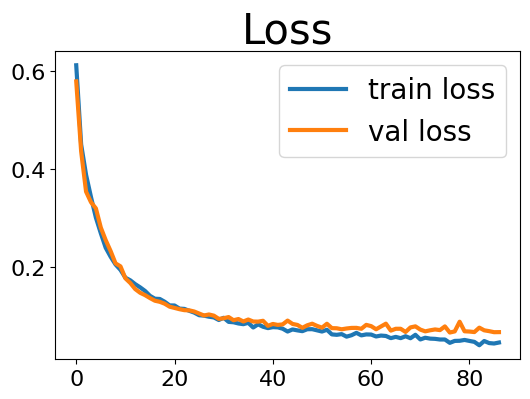

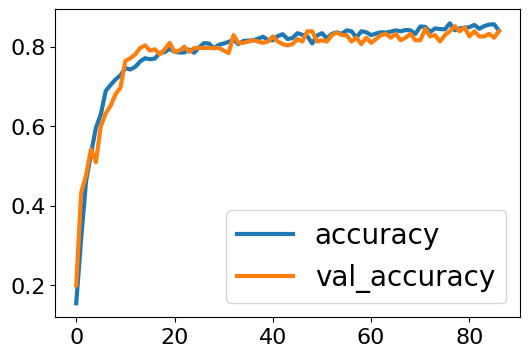

In [48]:
ch.plot_history(history, figsize=(6,4))

In [52]:
#best_model.save("model/mlc_algorithm_adaption_mlp_optuna_v2.4.h5")

In [19]:
best_model = load_model("model/mlc_algorithm_adaption_mlp_optuna_v2.4.h5")

# 3. Evaluation of optimized model and saving the results

In [20]:
prediction = best_model.predict(x_test)
y_pred = ch.make_pred_mlc(prediction, threshold=0.5)
acc, ham = ch.mlc_result(y_test, y_pred)

24/24 [==============================] - 4s 4ms/step


acc: 0.8066666666666666
hamming loss: 0.033166666666666664

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.953     0.820     0.882       100
           2      0.922     0.890     0.906       200
           3      0.956     0.980     0.968       200
           4      0.724     0.840     0.778       100
           5      0.889     0.853     0.871       150
           6      0.973     0.947     0.959       150
           7      0.937     0.948     0.942       250

   micro avg      0.920     0.914     0.917      1200
   macro avg      0.919     0.910     0.913      1200
weighted avg      0.922     0.914     0.917      1200
 samples avg      0.919     0.922     0.910      1200



In [21]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,12,14,16,24,25,26,27,35,37,45,46,47,57,126,246,247,267,347,357,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,41,1,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,50
2,0,1,34,0,1,2,0,0,1,0,0,7,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,50
3,0,0,0,49,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,0,0,37,0,0,0,0,0,0,6,0,0,0,2,0,0,0,2,1,0,0,1,0,0,1,0,50
5,0,0,1,0,0,42,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,4,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,1,0,0,41,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,0,0,1,0,50
16,0,1,0,0,1,1,5,0,0,0,36,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,3,50


In [22]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[646,   4],
        [ 18,  82]],

       [[535,  15],
        [ 22, 178]],

       [[541,   9],
        [  4, 196]],

       [[618,  32],
        [ 16,  84]],

       [[584,  16],
        [ 22, 128]],

       [[596,   4],
        [  8, 142]],

       [[484,  16],
        [ 13, 237]]], dtype=int64)

In [24]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [25]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

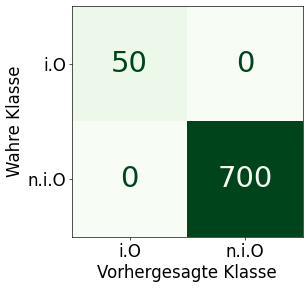

In [29]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], figsize=(5,5), dpi=60)

In [30]:
best_param = {'dropout': 0.3,
                 'dense_layer': 2,
                 'bn_dense': True,
                 'bn_dense_position': 1,
                 'dropout_dense': True,
                 'unit1': 120,
                 'unit2': 80,
                 'lr': 0.00024034488798888818,
                 'batch_size': 16}
best_param

{'dropout': 0.3,
 'dense_layer': 2,
 'bn_dense': True,
 'bn_dense_position': 1,
 'dropout_dense': True,
 'unit1': 120,
 'unit2': 80,
 'lr': 0.00024034488798888818,
 'batch_size': 16}

In [31]:
res = ch.collect_results_mlc(y_test, y_pred, algorithm="feature_based_mlp", params="optuna", best_param=best_param)
res

{'algorithm': 'feature_based_mlp',
 'params': 'optuna',
 'best_param': {'dropout': 0.3,
  'dense_layer': 2,
  'bn_dense': True,
  'bn_dense_position': 1,
  'dropout_dense': True,
  'unit1': 120,
  'unit2': 80,
  'lr': 0.00024034488798888818,
  'batch_size': 16},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.9141666666666667,
 'pre_weighted': 0.9223763072245758,
 'f1_weighted': 0.9173484967440573,
 'acc': 0.8066666666666666}

In [32]:
#ch.save_results_json(filename="mlc_algorithm_adaption_hyperopt_results_v2.4.json", 
                     key_algorithm = "mlp", 
                     hyperopt_result = res)

existing file mlc_algorithm_adaption_hyperopt_results_v2.4.json opened and results of mlp saved.
